# Project: House Price Prediction

### Introduction to Data Science

1. Hoang Truong Minh
2. Huong Nguyen Thi Xuan
3. Linh Phan Ngoc Thi
4. Thu Ho Tran Anh


# Outline
- [ 1 - Objective ](#1)
- [ 2 - Packages ](#2)
- [ 3 - Data Collection ](#3)
- [ 4 - Data Preprocessing ](#4)
- [ 5 - Feature Engineering ](#5)
- [ 6 - Methodology ](#6)
- [ 7 - Self-Assessment ](#7)

<a name="1"></a>
## 1. Objective
- Demonstrate end-to-end skills in data scraping, data
preprocessing, feature engineering, modeling, an evaluation
- Predict house prices using machine learning models..

<a name="2"></a>
## 2. Packages
Import all the packages that we will need during this lab.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from bs4 import BeautifulSoup
import urllib.request
import re
import time
import random as ran
from geopy.geocoders import Nominatim
import geopandas as gpd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'firefox'

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

<a name="3"></a>
## 3. Data Collection
We will scrape and collect data items from the website https://batdongsan.vn/ban-nha/ to create a comprehensive dataset

Trong 1 bài đăng, ta có thể lấy những thông tin có ích ở những nơi sau:
1. **Price**
2. **Time**
3. **Location**
    - Tỉnh
    - Quận, huyện
4. **Parameter**
    - Area
    - Bedroom
    - WC
5. **Title**
    - Mặt tiền / hẻm
    - Tầng
6. **Content** (nếu các features chưa có ở các mục trên)
    - Mặt tiền / hẻm
    - Tầng
    - Bedroom
    - WC

### Scrape raw data
Trước hết chúng ta sẽ lấy từng mục dữ liệu thô từ từng bài đăng. Các mục có thể cào là:
- Price: mục chứa giá tiền, có thể mang giá trị căn nhà do người đăng chỉ định hoặc 'Thỏa thuận' (sau này khi trích xuất ra dữ liệu có ích ta sẽ xem 'Thỏa thuận' là missing value vì chưa biết giá tiền)
- Time: ngày đăng bài
- Location: chứa tỉnh và quận của ngôi nhà trong bài đăng
- Param: các giá trị được người đăng điền như diện tích, số phòng ngủ, số WC,...
- Title: tiêu đề của bài đăng
- Content: mô tả về căn nhà do người đăng viết
- Poster: tên tài khoản người đăng bài
- Url: đường link dẫn đến bài đăng

![](/Users/xuannguyet/Documents/UniLife/dspj/crawl.png)

In [ ]:
def download_html(url):
    with urllib.request.urlopen(url) as response:
        html = response.read()
        html = html.decode('utf-8')
    response.close()
    return html

In [ ]:
# Hàm cào dữ liệu của 1 bài đăng bán nhà
def scrape_one_block(block):
  raw_data = {}

  raw_data['price'] = block.find('strong', {'class': 'price'}).get_text().strip()
  raw_data['time'] = block.find('time', {'class' : 'timeago'}).get('datetime')
  raw_data['location'] = block.find('ul', {'class': 'uk-breadcrumb'}).get_text()
  raw_data['param'] = block.find('div', {'class': 'param'}).get_text()
  raw_data['title'] = block.find('h1', {'class': 'uk-panel-title'}).get_text()
  raw_data['content'] = block.find('div', {'class': 'content'}).get_text()
  raw_data['poster'] = block.find('div', {'class': 'name'}).get_text()


  return raw_data

In [ ]:
# Hàm cào 1 trang trong website bán nhà
def scrape_one_page(blocks):
  raw_data = []

  for div in blocks:
    post_url = div.find('a').get('href')
    html = download_html(post_url)
    soup = BeautifulSoup(html, 'lxml')
    block_data = scrape_one_block(soup)
    block_data['url'] = post_url
    raw_data.append(block_data)

  return raw_data

In [ ]:
# Hàm cào cho tới khi đủ số lượng target data
def scrape_raw_data(link, target_count):
  raw_data = []

  curr_count = 0
  page_number = 1

  while curr_count < target_count:
    start_time = time.time()

    url = link + 'p' + str(page_number)

    try:
      source = download_html(url)
      soup = BeautifulSoup(source, 'lxml')

      house_grid = soup.find('div', {'class': 'uk-grid uk-grid-small uk-grid-width-1-1'})
      house_blocks = house_grid.findAll('div', {'class': 'name'})

      raw_data.extend(scrape_one_page(house_blocks))
    except Exception as e:
      print(f'Error catched: {e}')
      page_number += 1 # Neu gap loi thi chuyen sang cao trang tiep theo
      time.sleep(60)
      continue

    curr_count += len(house_blocks)

    stop_time = time.time()

    print(f'Scraped page: {str(page_number)} \tTime: {str(stop_time - start_time)}')

    page_number += 1

    time.sleep(ran.randint(1, 5))

  return raw_data

Ta sẽ tiến hành cào dữ liệu thô

In [ ]:
# url = 'https://batdongsan.vn/ban-nha/'

# target_scrape = 10000

# raw_data = scrape_raw_data(url, target_scrape)
# raw_data = pd.DataFrame(raw_data)
# raw_data.to_csv('raw_data.csv', index=False)

### Transform raw data into useful data
Vì chúng ta chỉ mới có các dữ liệu thô từ các mục trong bài đăng, ta cần phải trích xuất từ dữ liệu thô đó sang các features có ích.

Ở đây chúng ta sẽ dùng RegEx và LLM để trích xuất các features.

__Note:__
- Trong quá trình dùng RegEx để chuyển đổi đã cố gắng hạn chế tối thiểu missing value có thể có của từng features bằng cách tìm các pattern có thể xảy ra của từng mục trong bài đăng.
- Đã bỏ qua các feature có quá nhiều null trong bước này như "sổ hồng chính chủ hay không?",... trong lúc trích xuất dữ liệu


***Using RegEx:***

*Ở đây chúng ta lấy ra các cột `poster`, `title`, `description`, `url` để có thể xử lý dữ liệu ở các bước sau này (ta sẽ drop chúng sau)*

In [ ]:
def transform_data(raw_data):
  data = {}

  try:
    data['area'] = float(re.search(r'Diện tích: (\d+[.,]?\d?) m2', raw_data['param']).group(1).replace(',', '.'))
  except:
    try:
      area = re.search(r'((\d+[.,]?\d*)\s*(?=m2))|((\d+[.,]?\d*)[m]?\s*x\s*(\d+[.,]?\d*)[m]?)', raw_data['content']).group().replace(',', '.')
      data['area'] = 1
      for num in list(map(float, re.findall(r'\d+[.]?\d?', area))):
          data['area'] *= num
    except:
      data['area'] = None

  try:
    data['bedroom'] = int(re.search(r'Phòng ngủ: (\d+) PN', raw_data['param']).group(1))
  except:
    data['bedroom'] = None

  try:
    data['wc'] = int(re.search(r'Phòng WC: (\d+) WC', raw_data['param']).group(1))
  except:
    data['wc'] = None

  try:
    data['floor'] = int(re.search(r'(\d+)\s?tầng', raw_data['title'], re.IGNORECASE).group(1))
  except:
    try:
      matches = re.findall(r'(\d+)\s?tầng|tầng\s?(\d+)', raw_data['content'], re.IGNORECASE)
      floors = [int(num) for match in matches for num in match if num]
      data['floor'] = max(floors)
    except:
      try: # Neu la 'lau' thi +1 vao floor
        data['floor'] = int(re.search(r'(\d+)\s?lầu', raw_data['title'], re.IGNORECASE).group(1)) + 1
      except:
        try:
          data['floor'] = int(re.search(r'(\d+)\s?lầu', raw_data['content'], re.IGNORECASE).group(1)) + 1
        except:
          # Neu la nha gac lung thi la nha 1 tang
          if re.search(r'lửng', raw_data['content'], re.IGNORECASE):
            data['floor'] = 1
          else:
            data['floor'] = None

  data['frontage'] = bool(re.search(r'mặt tiền|mặt đường|mặt phố', raw_data['location'].split('\n')[2], re.IGNORECASE))\
                  or bool(re.search(r'mặt tiền|mặt đường|mặt phố', raw_data['title'], re.IGNORECASE)) \
                  or bool(re.search(r'mặt tiền|mặt đường|mặt phố', raw_data['content'], re.IGNORECASE))

  try:
    data['house_type'] = raw_data['location'].split('\n')[2]
  except:
    data['house_type'] = None

  try:
    data['province'] = raw_data['location'].split('\n')[3]
  except:
    data['province'] = None

  try:
    data['district'] = raw_data['location'].split('\n')[4]
  except:
    data['district'] = None

  try:
      data['datetime'] = raw_data['time']
  except:
      data['datetime'] = None

  try:
    data['price'] = re.search(r'\d+[.]?\d?\s\w+', raw_data['price']).group()
  except:
    try:
      total_price = data['area'] * float(re.search(r'(\d+[.,]?\d?)\s?\w+\s?/\s?m2', raw_data['title'], re.IGNORECASE).group(1).replace(',', '.'))
      data['price'] = str(total_price) + str(re.search(r'\d+\s?(\w+)\s?/\s?m2', raw_data['title'], re.IGNORECASE).group(1))
    except:
      try:
        total_price = data['area'] * float(re.search(r'(\d+[.,]?\d?)\s?\w+\s?/\s?m2', raw_data['content'], re.IGNORECASE).group(1).replace(',', '.'))
        data['price'] = str(total_price) + str(re.search(r'\d+\s?(\w+)\s?/\s?m2', raw_data['content'], re.IGNORECASE).group(1))
      except:
        try:
          data['price'] = re.search(r'(\d+[.,]?\d?)\s?(tỷ|tỉ|tỏi)', raw_data['title'], re.IGNORECASE).group().replace(',', '.')
        except:
            try:
                data['price'] = re.search(r'(\d+[.,]?\d?)\s?(tỷ|tỉ|tỏi)', raw_data['content'], re.IGNORECASE).group().replace(',', '.')
            except:
                try:
                    data['price'] = re.search(r'(\d+[.,]?\d?)\s?(triệu|tr)', raw_data['title'], re.IGNORECASE).group().replace(',', '.')
                except:
                  try:
                    data['price'] = re.search(r'(\d+[.,]?\d?)\s?(triệu|tr)', raw_data['content'], re.IGNORECASE).group().replace(',', '.')
                  except:
                    data['price'] = None

  data['title'] = raw_data['title']
  data['description'] = raw_data['content']

  return data

***Using LLM:***

- Với 3 features: `bedroom`, `wc`, `frontage`, sau khi thực hiện RegEx, nhóm dùng LLM model của Anyscale để trích xuất dữ liệu từ phần description và title để hạn chế tối đa sự sai sót mà RegEx mang lại.
- Mặc dù có thể dùng mỗi RegEx, tuy nhiên, bản thân title và description là những ngôn ngữ tự nhiên với ngữ cảnh phức tạp, cho nên RegEx sẽ bị hạn chế trong việc xử lý các cấu trúc ngữ pháp phức tạp và các biểu hiện ngôn ngữ tự nhiên đa dạng.

In [ ]:
def extract_info(description):
    # api connection from anyscale
    s = requests.Session()
    api_base = "https://api.endpoints.anyscale.com/v1"
    # Replace with long-lived credentials for production
    token = "esecret_wrhq6a2ejle2tu7m4wbgqv62w6"
    url = f"{api_base}/chat/completions"

    body = {
    "model": "meta-llama/Meta-Llama-3-70B-Instruct",
    "messages": [
        {
        "role": "user",
        "content": "Hay tra ve ket qua duoi dang json {\"bedroom\":..., \" wc\":..., \"frontage\":...}"
        },
        {
        "role": "assistant",
        "content": ""
        },
        {
        "role": "user",
        "content": "bedroom la tong so phong ngu, wc la tong so phong tam hoac phong ve sinh"
        },
        {
        "role": "assistant",
        "content": ""
        },
        {
        "role": "user",
        "content": "de cap den nha pho, nha mat tien thi frontage tra ve True"
        },
        {
         "role": "assistant",
         "content": ""
        },
        {
        "role": "user",
        "content": str(description)
        },
        {
        "role": "assistant",
        "content": ""
        },
        {
        "role": "user",
        "content": "khong them ghi chu"
        },
        {
        "role": "assistant",
        "content": ""
        },
        {
        "role": "user",
        "content": "bedroom, wc chi tra ve dang so"
        },
        {
        "role": "assistant",
        "content": ""
        },
        {
        "role": "user",
        "content": "true/false tra ve dang chuoi ki tu"
        },
        {
         "role": "assistant",
         "content": ""
        },
        {
        "role": "user",
        "content": "tuyet doi khong tra ve 0, khong de cap den thi tra ve null, khong co thi tra ve null."
        },
        # {
        # "role": "assistant",
        # "content": ""
        # }
    ],
    "temperature": 1,
    "max_tokens": 256,
    "top_p": 1,
    "frequency_penalty": 0
    }

    headers = {
        "Authorization": f"Bearer {token}",
        "Content-Type": "application/json"
    }


    for i in range(3):
        try:
            response = requests.post(url, headers=headers, data=json.dumps(body))
            response.raise_for_status()  # Raise an error for bad status codes
            data = response.json()
            result = data['choices'][0]['message']['content']
            json_match = re.search(r"\{\s*\"bedroom\":.*\}", result, re.DOTALL)
            if json_match:
                json_str = json_match.group(0)
                house_info = json.loads(json_str)
                return house_info
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}, retrying in seconds...")
            time.sleep(60)
        except Exception as e:
            print(f"Error processing response: {e}")
            return None
    return None

In [ ]:
# Hàm trích xuất thông tin bedroom, wc từ assistant content thay thế cho missing value
def transform_room(data):
    empty_room = data[(data['bedroom'].isna()) | (data['wc'].isna())]

    curr_count = 0
    num = len(empty_room)
    index = empty_room.index.tolist()

    for i in index:
        start_time = time.time()

        try:
            assistant_content = extract_info(empty_room['description'][i])
            room_info = re.search(r"'bedroom':\s*(\d+).*?'wc':\s*(\w+)", str(assistant_content))
            if room_info:
                bedroom = room_info.group(1)
                wc = room_info.group(2)
                if bedroom is not None:
                    data.at[i, 'bedroom'] = int(bedroom)
                if wc is not None:
                    data.at[i, 'wc'] = int(wc)
        except Exception as e:
            print(f'Error catched: {e}')

        stop_time = time.time()

        print(f'Transformed index: {str(i)} \tTime: {str(stop_time - start_time)}')
        time.sleep(ran.randint(1, 5))

    return data

In [ ]:
def check_not_frontage(info):
    return bool(re.search(r'ra mặt|sát mặt|cạnh mặt|cách mặt|gần mặt', info, re.IGNORECASE))

# Hàm kiểm tra lại frontage frontage == True
def transform_frontage(data):
    indices = data[data['frontage']==True].index.tolist()
    for i in indices:
        start_time = time.time()
        try:
            if check_not_frontage(data.at[i,'title']):
                data.at[i,'frontage'] = False
            else:
                assistant_content = extract_info(data['content'][i])
                data.at[i,'frontage'] = assistant_content['frontage']
        except Exception as e:
            print(f'Error catched: {e}')

        stop_time = time.time()

        print(f'Transformed index: {str(i)} \tTime: {str(stop_time - start_time)}')
        time.sleep(ran.randint(1, 5))

    return data

<a name="4"></a>
## 4. Data Preprocessing

Trước hết ta sẽ truy xuất các cột có ích từ dữ liệu thô đã cào về thành 1 dataframe và lưu vào file csv

In [ ]:
# raw_data = pd.read_csv('raw_data.csv')
# raw_data

In [ ]:
# data = raw_data.apply(transform_data, axis = 1).tolist()
# data = pd.DataFrame(data)
# data = transform_room(data)
# final_data = transform_frontage(data)
# final_data.to_csv('house_price_final_dataset.csv', index=False)

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/nauxqouh/house_data/main/transformed_data.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   area         9586 non-null   float64
 1   bedroom      9433 non-null   float64
 2   wc           7695 non-null   float64
 3   floor        8252 non-null   float64
 4   frontage     10000 non-null  bool   
 5   house_type   10000 non-null  object 
 6   province     10000 non-null  object 
 7   district     10000 non-null  object 
 8   datetime     10000 non-null  object 
 9   description  10000 non-null  object 
 10  title        10000 non-null  object 
 11  price        9773 non-null   object 
dtypes: bool(1), float64(4), object(7)
memory usage: 869.3+ KB


*Vì giá nhà của từng bài đăng không có đơn vị giống nhau (tỷ, triệu) nên ta giữ nguyên kiểu dữ liệu của cột `price` là object để có thể chuyển đổi về cùng đơn vị sau này*

In [ ]:
# Xem 5 dòng đầu của dữ liệu
data.head()

area  bedroom   wc  floor  frontage     house_type        province  \
0  150.0      2.0  1.0    NaN     False  Bán Nhà riêng  TP Hồ Chí Minh   
1   51.0      3.0  NaN    3.0     False  Bán Nhà riêng  TP Hồ Chí Minh   
2   45.0      2.0  2.0    2.0     False        Bán Nhà  TP Hồ Chí Minh   
3   41.0      2.0  NaN    2.0     False  Bán Nhà riêng  TP Hồ Chí Minh   
4   96.0      2.0  1.0    1.0     False  Bán Nhà riêng  TP Hồ Chí Minh   

    district             datetime  \
0     Nhà Bè  2023-12-10 17:11:02   
1   Tân Bình  2023-12-10 18:40:26   
2  Phú Nhuận  2023-12-10 18:56:17   
3     Quận 5  2023-12-10 20:49:28   
4    Tân Phú  2023-12-07 14:13:40   

                                         description  \
0  \nMô tả: \r\n+ Thông số cực đẹp 5 x 30m (15...   
1  \nBán nhà HXH Âu Cơ Phường 9 Tân Bình, 51m2 3 ...   
2  \n- Kết cấu: 1 trệt 1 lầu BTCT; 2 PN, 2 WC. Ph...   
3  \nMô tả:\r\n- Diện tích công nhận 41m, thực tế...   
4  \n- Diện tích 96m2 ngang 4.3m dài 22.5m .\r\n-...   

                                               title          price  
0  Chưa tới 30tr/m2 - Hàng ngộp bank BAO ĐẦU TƯ ...  3899000000 tỷ  
1  Bán nhà HXH Âu Cơ Phường 9 Tân Bình, 51m2 3 Tầ...         5.5 tỷ  
2  SÁT MẶT TIỀN PHAN ĐĂNG LƯU, PHƯỜNG 7, PHÚ NHUẬ...         4.6 tỷ  
3  CHỦ GẤP BÁN TRƯỚC TẾT LÊ HỒNG PHONG QUẬN 5 RA ...          35 tỷ  
4  LŨY BÁN BÍCH,TÂN PHÚ-DIỆN TÍCH KHỦNG 96M2 ( 4....            5TỶ

In [ ]:
# Xem 5 dòng cuối của dữ liệu
data.tail()

area  bedroom   wc  floor  frontage       house_type        province  \
9995  100.0      4.0  4.0    3.0     False  Bán Nhà mặt phố         Đà Nẵng   
9996   44.1      5.0  4.0    5.0     False    Bán Nhà riêng  TP Hồ Chí Minh   
9997   52.0      1.0  NaN    NaN     False    Bán Nhà riêng  TP Hồ Chí Minh   
9998   14.0      2.0  3.0    3.0     False    Bán Nhà riêng  TP Hồ Chí Minh   
9999  127.0      3.0  2.0    NaN     False  Bán Nhà mặt phố  TP Hồ Chí Minh   

        district             datetime  \
9995      Cẩm Lệ  2023-04-20 06:51:25   
9996  Bình Thạnh  2023-04-20 07:49:32   
9997      Gò Vấp  2023-04-20 08:28:18   
9998      Quận 1  2023-04-20 08:53:57   
9999   Phú Nhuận  2023-04-20 09:03:07   

                                            description  \
9995  \nMô Tả:\r\n+ Ngay vị trí đắc địa ngay sát đườ...   
9996  \nNhà kiểu dáng Châu Âu, có sẵn nội thất: tivi...   
9997  \nMS 7923\r\n* Vị trí: hẻm 1 sẹc đường Huỳnh V...   
9998  \n-  Nhà 1 trệt, 2 lầu, 1 sân thượng, 3 toilet...   
9999  \nBán gấp nhà MT đường Phan Đình Phùng P...   

                                                  title       price  
9995  Bán đất gấp nhà MT Bình Hòa 4,Cẩm Lệ,100m2x3tầ...  5700000 tỷ  
9996  NHÀ ĐẸP 4 LẦU 5 PN ĐƯỜNG LÊ QUANG ĐỊNH QUẬN BÌ...       95 tỷ  
9997  Nhà C4 hẻm 1 sẹc Huỳnh Văn Nghệ Phường 12 Gò V...        4 tỷ  
9998                   NHÀ HẺM 148 BÙI VIỆN Q1 GIÁ 2ty5        1 tr  
9999  Giảm ngay 10 tỷ, bán gấp nhà MT Phan Đìn...       63 tỷ

In [ ]:
data.shape

(10000, 12)

In [ ]:
# Xem số lượng và tỷ lệ missing values của data
def calculate_missing_data(data):
    missing_data = pd.DataFrame({
        'column_name': data.columns,
        'total_missing': data.isnull().sum(),
        '%_missing': data.isnull().sum() * 100 / len(data)
    }).reset_index(drop=True)

    return missing_data

calculate_missing_data(data)

column_name  total_missing  %_missing
0          area            414       4.14
1       bedroom            567       5.67
2            wc           2305      23.05
3         floor           1748      17.48
4      frontage              0       0.00
5    house_type              0       0.00
6      province              0       0.00
7      district              0       0.00
8      datetime              0       0.00
9   description              0       0.00
10        title              0       0.00
11        price            227       2.27

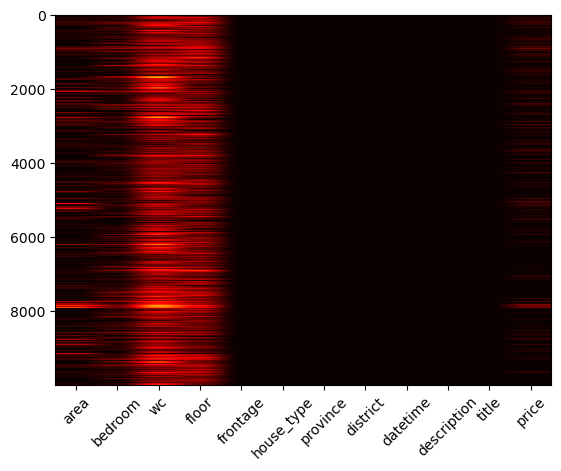

In [ ]:
# Biểu đồ thể hiện missing value của từng cột
plt.imshow(data.isnull(), cmap='hot', aspect='auto')
plt.xticks(ticks=np.arange(len(data.columns)), labels=data.columns, rotation=45)
plt.show()

Ta có thể thấy `bedroom`, `wc`, `floor` có nhiều giá trị khuyết nhất, tiếp đến là `area`, `price` có các giá trị khuyết do ở trạng thái *'Thỏa thuận'*.

### Change type of `price`

Cột `price` đang ở kiểu dữ liệu object, ta cần chuyển nó về float như đã nói ở trên với cùng đơn vị tỷ

In [ ]:
def convert_price(price_str): # định dạng: float, đơn vị: tỷ
    if pd.isnull(price_str): # trường hợp không có giá
        return None

    if re.search(r'triệu|tr', price_str, re.IGNORECASE): # trường hợp đơn vị triệu
        try:
            return float(re.search(r'\d+[.]?\d?', price_str).group()) / 1000
        except:
            return None

    if re.search(r'ng', price_str, re.IGNORECASE): #  trường hợp đơn vị ngàn
        try:
            return float(re.search(r'\d+[.]?\d?', price_str).group()) / 1000000
        except:
            return None

    return float(re.search(r'\d+[.]?\d?', price_str).group()) # trường hợp: đơn vị tỷ/ kh có đơn vị

In [ ]:
# Chuyển cột price về cùng đơn vị tỷ
data['price'] = data['price'].apply(convert_price)

In [ ]:
data['price'].dtypes

dtype('float64')

### Remove duplicated rows

In [ ]:
# Check duplicate
data.duplicated(subset=[col for col in data.columns if col != 'frontage']).sum()

501

In [ ]:
# Xuất xem trùng lặp ở đâu
data[data.duplicated(subset=[col for col in data.columns if col != 'frontage'], keep=False)]

area  bedroom   wc  floor  frontage       house_type        province  \
5      40.0      4.0  3.0    NaN     False    Bán Nhà riêng          Hà Nội   
6      40.0      4.0  3.0    NaN     False    Bán Nhà riêng          Hà Nội   
20    110.0      3.0  2.0    1.0     False    Bán Nhà riêng        Đồng Nai   
21    110.0      3.0  2.0    1.0     False    Bán Nhà riêng        Đồng Nai   
42    138.0      5.0  6.0    3.0      True  Bán Nhà mặt phố       Khánh Hòa   
...     ...      ...  ...    ...       ...              ...             ...   
9912   87.0      3.0  2.0    2.0     False  Bán Nhà mặt phố  TP Hồ Chí Minh   
9938   14.0      3.0  2.0    5.0     False    Bán Nhà riêng          Hà Nội   
9939   14.0      3.0  2.0    5.0     False    Bán Nhà riêng          Hà Nội   
9970   52.0      2.0  NaN    2.0     False          Bán Nhà  TP Hồ Chí Minh   
9971   52.0      2.0  NaN    2.0     False          Bán Nhà  TP Hồ Chí Minh   

        district             datetime  \
5        Hà Đông  2023-12-08 07:46:03   
6        Hà Đông  2023-12-08 07:46:03   
20      Vĩnh Cửu  2023-12-08 13:54:19   
21      Vĩnh Cửu  2023-12-08 13:54:19   
42     Nha Trang  2023-12-09 11:14:03   
...          ...                  ...   
9912     Thủ Đức  2023-04-22 10:02:39   
9938     Đống Đa  2023-04-21 13:05:04   
9939     Đống Đa  2023-04-21 13:05:04   
9970  Bình Thạnh  2023-04-19 13:42:41   
9971  Bình Thạnh  2023-04-19 13:42:41   

                                            description  \
5     \n- Vị trí khu vực trung tâm phường La Khê- Hà...   
6     \n- Vị trí khu vực trung tâm phường La Khê- Hà...   
20    \n???????? Bán nhà mới leng keng 110m2 SHR thổ...   
21    \n???????? Bán nhà mới leng keng 110m2 SHR thổ...   
42    \n(VH25) BÁN NHÀ 3 TẦNG MẶT TIỀN ĐƯỜNG 19/5 KH...   
...                                                 ...   
9912  \nBán nhà sát ngã ba MTĐ, HXH, nhà 1 trệt, 1 l...   
9938  \n- Nhà dân xây chắc chắn từ tầng 2 xây đưa ra...   
9939  \n- Nhà dân xây chắc chắn từ tầng 2 xây đưa ra...   
9970  \nBán Nhà - Hẻm Ba Gác - 2 Tầng - 52m2 / 5,1 T...   
9971  \nBán Nhà - Hẻm Ba Gác - 2 Tầng - 52m2 / 5,1 T...   

                                                  title      price  
5     Bán nhà trong ngõ Lê Trọng Tấn, TK hiện đại, 4...       95.0  
6     Bán nhà trong ngõ Lê Trọng Tấn, TK hiện đại, 4...       95.0  
20    Bán nhà mới leng keng 110m2 đường ô tô (X.Tân ...        1.6  
21    Bán nhà mới leng keng 110m2 đường ô tô (X.Tân ...        1.6  
42    (VH25) BÁN NHÀ 3 TẦNG MẶT TIỀN ĐƯỜNG 19/5 KHU ...        9.2  
...                                                 ...        ...  
9912  Bán nhà sát ngã ba MTĐ, HXH, nhà 1 trệt, 1 lầu...  6800000.0  
9938  HIẾM - TRUNG TÂM QUẬN ĐỐNG ĐA  - GẦN Ô TÔ - 5 ...       45.0  
9939  HIẾM - TRUNG TÂM QUẬN ĐỐNG ĐA  - GẦN Ô TÔ - 5 ...       45.0  
9970  Bán Nhà - Hẻm Ba Gác - Điện Biên Phủ - P15 Bìn...       51.0  
9971  Bán Nhà - Hẻm Ba Gác - Điện Biên Phủ - P15 Bìn...       51.0  

[1002 rows x 12 columns]

In [ ]:
# Drop duplicate
data = data.drop_duplicates(subset=[col for col in data.columns if col != 'frontage'])

In [ ]:
data.shape

(9499, 12)

### Handling outliers
__Note:__
*`bedroom`, `wc`, `floor`, `price` có độ chênh lệch giữa max-min rất lớn, chứng tỏ dataset xuất hiện outlier.*

#### Xử lý các giá trị bất thường của price

Trong lúc thu thập dữ liệu, nhóm phát hiện phần price được đề cập ở mục price đôi khi bị đăng sai do tính chất muốn gây sự chú ý của người đăng bài. Do đó, ta sẽ tìm lại các giá trị ở cột `price` lớn hơn 1000 và bé hơn 0.1, nếu đã tìm hết các pattern mà chúng vẫn lớn hơn 1000 và bé hơn 0.1 thì để chúng là None.

In [ ]:
def extract_price_from_text(text):
    try:
        price = re.search(r'(\d+[.,]?\d?)\s?(tỷ|tỉ|tỏi)', text, re.IGNORECASE).group().replace(',', '.')
        return price
    except:
        try:
            price = re.search(r'(\d+[.,]?\d?)\s?(triệu|tr)', text, re.IGNORECASE).group().replace(',', '.')
            return price
        except:
            return None

def calculate_total_price(row, column_name):
    try:
        price_per_m2 = float(re.search(r'(\d+[.,]?\d?)\s?\w+\s?/\s?m2', row[column_name], re.IGNORECASE).group(1).replace(',', '.'))
        total_price = row['area'] * price_per_m2
        unit = re.search(r'\d+\s?(\w+)\s?/\s?m2', row[column_name], re.IGNORECASE).group(1)
        return f"{total_price}{unit}"
    except:
        return None

def calculate_total_price_2(row, column_name):
    try:
        price_match = re.search(r'(\d+)\s?[.,]?\s?(tỷ|tỉ)\s?(\d+)', raw_data[column_name], re.IGNORECASE)
        price_main = float(price_match.group(1))
        price_sub = float(price_match.group(3)) / (10**len(price_match.group(3)))
        total_price = price_main + price_sub
        return total_price
    except:
        return None

def process_price(row, lower_bound, upper_bound):
    # Trường hợp chỉ có giá tiền /m2
    price = convert_price(calculate_total_price(row, 'title'))
    if price and (lower_bound < price < upper_bound):
        return price
    price = convert_price(calculate_total_price(row, 'description'))
    if price and (lower_bound < price < upper_bound):
        return price

    # Trường hợp x.y tỷ
    price = convert_price(extract_price_from_text(row['title']))
    if price and (lower_bound < price < upper_bound):
        return price
    price = convert_price(extract_price_from_text(row['description']))
    if price and (lower_bound < price < upper_bound):
        return price

    # Trường hợp x tỷ y
    price = convert_price(calculate_total_price_2(row, 'title'))
    if price and (lower_bound < price < upper_bound):
        return price
    price = convert_price(calculate_total_price_2(row, 'description'))
    if price and (lower_bound < price < upper_bound):
        return price

    # Nếu không tìm được ở các trường hợp trên thì return None
    return None

def handle_outlier_price(data, lower_bound, upper_bound):
    for index, row in data[(data['price'] >= upper_bound) | (data['price'] <= lower_bound)].iterrows():
        data.loc[index, 'price'] = process_price(row, lower_bound, upper_bound)

In [ ]:
handle_outlier_price(data, 0.1, 1000)
data[(data['price'] >= 1000) | (data['price'] <= 0.1)]

Empty DataFrame
Columns: [area, bedroom, wc, floor, frontage, house_type, province, district, datetime, description, title, price]
Index: []

Sau khi áp dụng phương pháp trên ta không còn hàng nào có `price` >= 1000 hoặc <= 0.1 nữa.

Từ đây ta không còn cần cột `title` và `description` nữa nên ta sẽ tiến hành drop chúng.

In [ ]:
data = data.drop(columns=['title', 'description'])

#### Xử lý outliers bằng IQR

Các giá trị outlier sẽ được thay bằng None.

In [ ]:
data.isna().sum()

area           399
bedroom        548
wc            2203
floor         1662
frontage         0
house_type       0
province         0
district         0
datetime         0
price          474
dtype: int64

In [ ]:
# Viết hàm IQR() để tính toán Q1, mean, Q3, IQR, lower_bound, upper_bound, outliers_num, outliers_percentage.
def IQR(data, column):
    """
    Tính toán các giá trị Q1, median, Q3, IQR, lower_bound, upper_bound, số lượng và tỷ lệ phần trăm outliers cho một cột trong DataFrame.
    Parameters:
    data (pd.DataFrame): DataFrame chứa dữ liệu.
    column (str): Tên cột cần tính toán.
    Returns:
    dict: Dictionary chứa các giá trị thống kê và thông tin về outliers.
    """
    Q1 = data[column].quantile(0.25)
    median = data[column].median()
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    outliers_num = outliers.shape[0]
    outliers_percentage = (outliers_num / len(data)) * 100

    return {
        'Q1': Q1,
        'median': median,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outliers_num': outliers_num,
        'outliers_percentage': outliers_percentage
    }


In [ ]:
# hàm chuyển kết quả của IQR thành dataframe
def iqr_df(data):
    """
    Tính IQR cho tất cả các cột kiểu số trong DataFrame và trả kết quả dưới dạng DataFrame.
    Parameters:
    data (pd.DataFrame): DataFrame chứa dữ liệu.
    Returns:
    pd.DataFrame: DataFrame chứa IQR cho từng cột kiểu số.
    """
    data_stats = {}
    for column in data.select_dtypes(include=['int64', 'float64']).columns:
        data_stats[column] = IQR(data, column)

    # Chuyển đổi dictionary sang DataFrame để dễ quan sát
    data_stats_df = pd.DataFrame(data_stats).T  # .T để chuyển đổi hàng thành cột và ngược lại

    return data_stats_df

data_stats_df = iqr_df(data)
data_stats_df

Q1  median    Q3   IQR  lower_bound  upper_bound  outliers_num  \
area     42.0    60.0  85.0  43.0       -22.50       149.50         743.0   
bedroom   2.0     3.0   4.0   2.0        -1.00         7.00         423.0   
wc        2.0     3.0   4.0   2.0        -1.00         7.00         231.0   
floor     2.0     3.0   5.0   3.0        -2.50         9.50          20.0   
price     4.3     6.8  18.0  13.7       -16.25        38.55        1411.0   

         outliers_percentage  
area                7.821876  
bedroom             4.453100  
wc                  2.431835  
floor               0.210548  
price              14.854195

In [ ]:
def plot_boxplot(data, columns):
    """
    Vẽ biểu đồ boxplot cho tất cả các cột trong DataFrame trên cùng một hàng.
    Parameters:
    data (pd.DataFrame): DataFrame chứa dữ liệu.
    columns (list): Danh sách các tên cột cần vẽ boxplot.
    """
    num_cols = len(columns)
    plt.figure(figsize=(6 * num_cols, 6))  # Kích thước của figure

    for i, col in enumerate(columns, start=1):
        plt.subplot(1, num_cols, i)
        sns.boxplot(data=data[col], color='skyblue')
        plt.title(f'{col}')
        plt.xlabel('')
        plt.ylabel('Values')

    plt.tight_layout()
    plt.show()


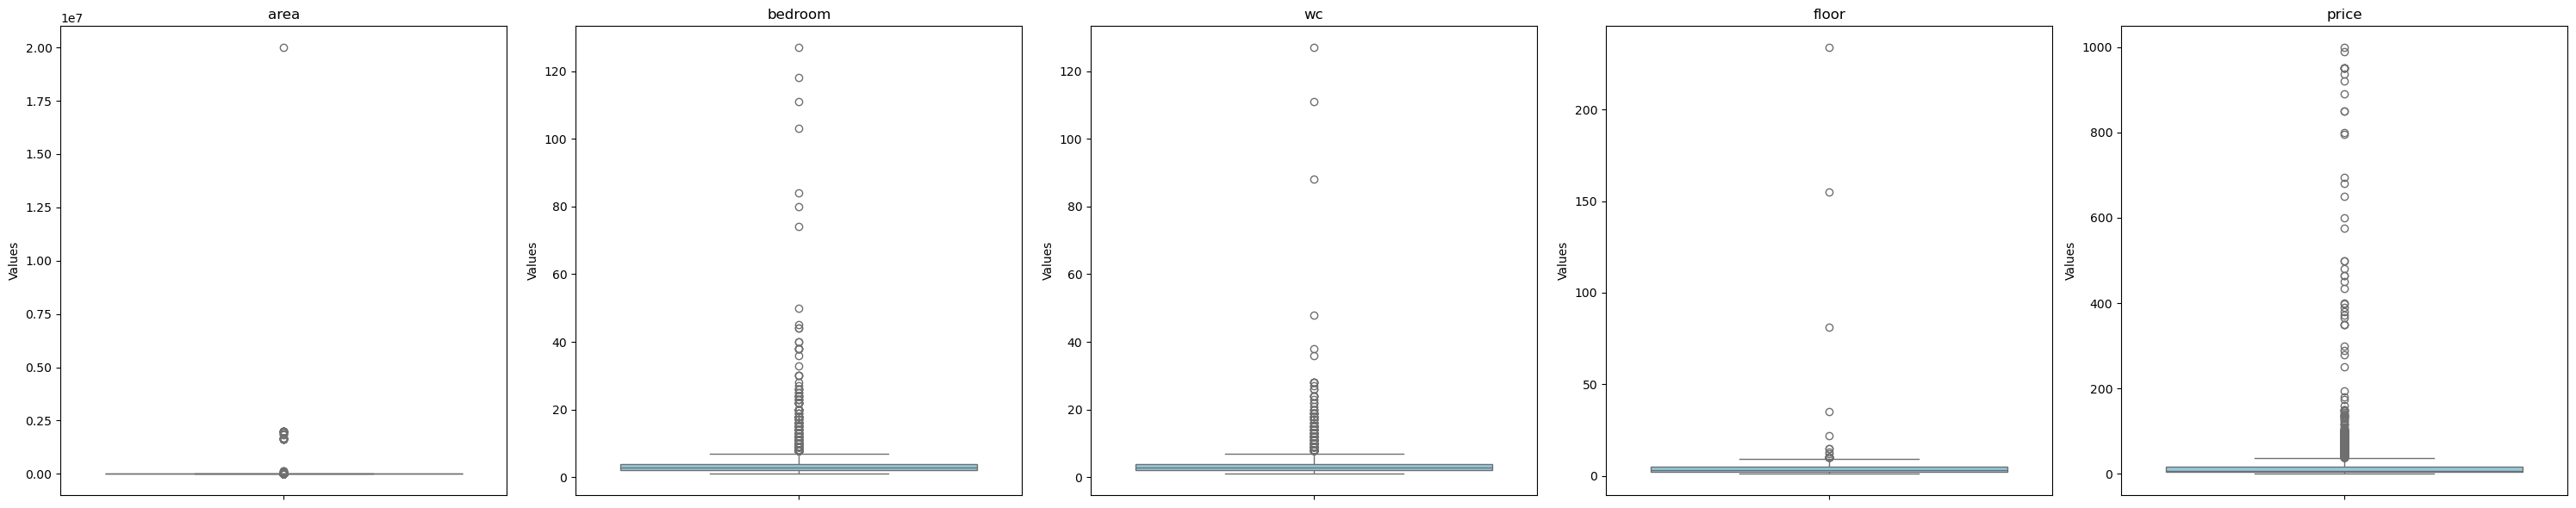

In [ ]:
# Lấy tất cả các cột numerical (ta sẽ không xét đến longitude và latitude vì đây là các giá trị thực tế)
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
# Vẽ boxplot cho tất cả các cột numerical
plot_boxplot(data, numerical_columns)

> Dữ liệu có nhiều outlier nên boxplot bị dồn về 1 phía.

In [ ]:
def handle_outliers(data, columns):
    """
    Thay các giá trị ngoại lai từ nhiều cột của DataFrame thành None bằng phương pháp IQR.
    Parameters:
    data (pd.DataFrame): DataFrame chứa dữ liệu.
    columns (list): Danh sách các tên cột cần loại bỏ ngoại lai.
    Returns:
    pd.DataFrame: DataFrame sau khi thay ngoại lai thành None.
    """
    for column in columns:
        iqr_values = IQR(data, column)
        lower_bound = iqr_values['lower_bound']
        upper_bound = iqr_values['upper_bound']
        # Thay hàng ngoài khoảng IQR và gán giá trị của chúng bằng None
        data.loc[(data[column] < lower_bound) | (data[column] > upper_bound), column] = None
    return data

In [ ]:
# Thay các giá trị outlier thành None
data = handle_outliers(data, numerical_columns)

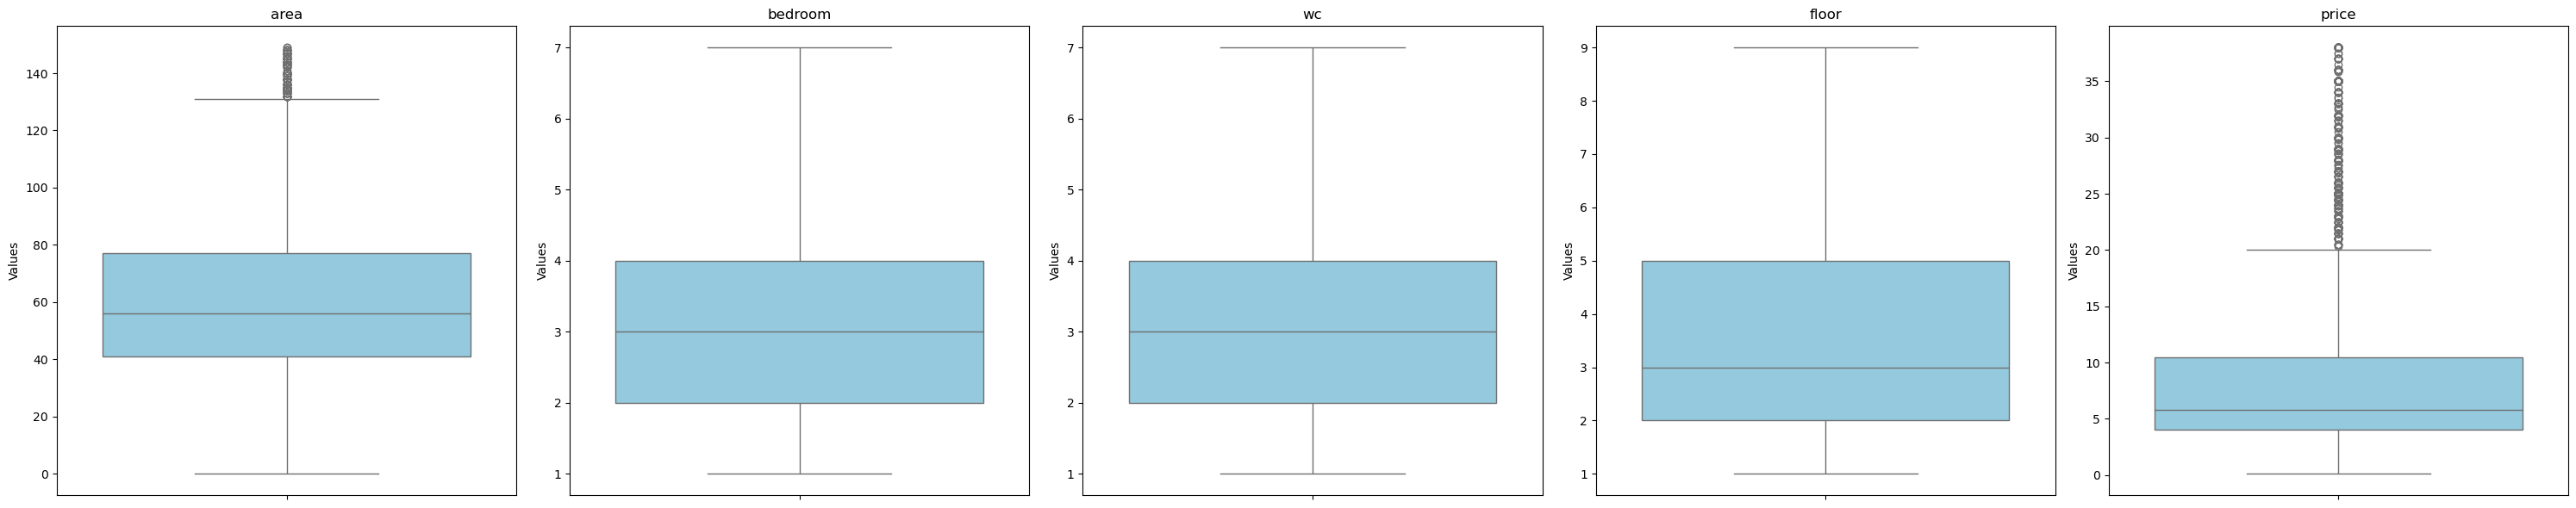

In [ ]:
# Vẽ biểu đồ boxplot
plot_boxplot(data, numerical_columns)

- Sau khi xử lí outlier bằng phương pháp IQR thì ta thâý boxplot không còn bị dồn về một phía.
- Ta thấy `bedroom`, `wc`, `floor` không còn outlier nữa.

In [ ]:
data.describe()

area      bedroom           wc        floor        price
count  8357.000000  8528.000000  7065.000000  7817.000000  7614.000000
mean     61.342869     3.347092     3.038358     3.549955     8.716944
std      26.904929     1.261170     1.351596     1.423175     7.857745
min       0.000000     1.000000     1.000000     1.000000     0.105000
25%      41.000000     2.000000     2.000000     2.000000     4.000000
50%      56.000000     3.000000     3.000000     3.000000     5.800000
75%      77.000000     4.000000     4.000000     5.000000    10.500000
max     149.000000     7.000000     7.000000     9.000000    38.000000

In [ ]:
data.isna().sum()

area          1142
bedroom        971
wc            2434
floor         1682
frontage         0
house_type       0
province         0
district         0
datetime         0
price         1885
dtype: int64

### Handling missing value

In [ ]:
calculate_missing_data(data)

column_name  total_missing  %_missing
0        area           1142  12.022318
1     bedroom            971  10.222129
2          wc           2434  25.623750
3       floor           1682  17.707127
4    frontage              0   0.000000
5  house_type              0   0.000000
6    province              0   0.000000
7    district              0   0.000000
8    datetime              0   0.000000
9       price           1885  19.844194

In [ ]:
# Xoá các dòng dữ liệu nhiễu mà có thành phần null nhiều.
data = data.dropna(thresh=2, subset=['area','bedroom','wc','floor'])
data.shape

(8919, 10)

In [ ]:
# Calculate correlation coefficients
corr_matrix = data.select_dtypes(include=['int64', 'float64', 'bool']).corr().round(2)
target_corr = corr_matrix['price']

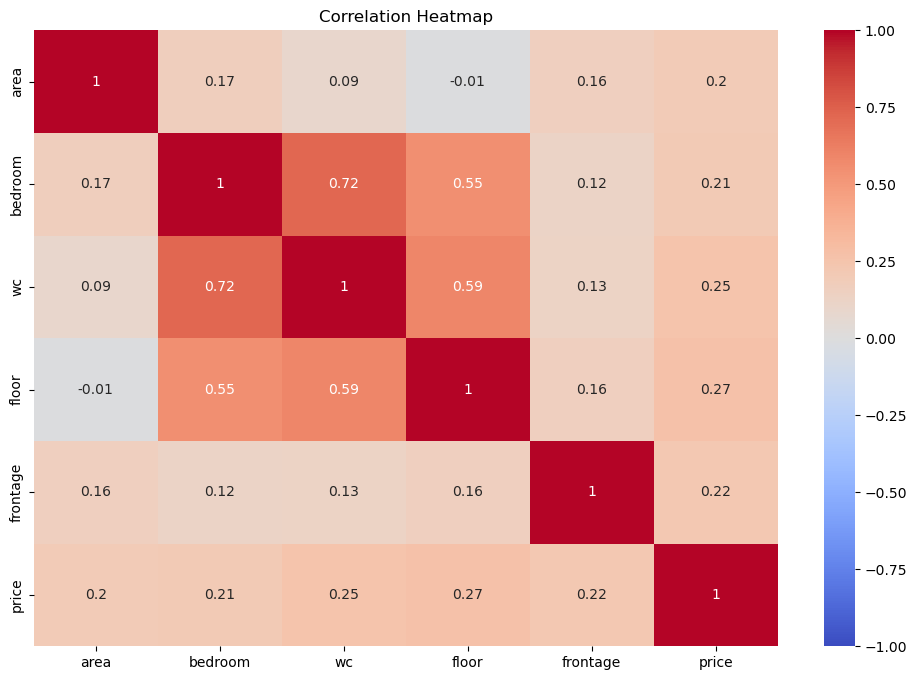

In [ ]:
# Visualize correlations with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
data.describe()

area      bedroom           wc        floor        price
count  8128.000000  8493.000000  7057.000000  7701.000000  7251.000000
mean     61.103686     3.348051     3.038402     3.531360     8.604258
std      26.752353     1.262300     1.351313     1.400634     7.791038
min       0.000000     1.000000     1.000000     1.000000     0.105000
25%      41.000000     2.000000     2.000000     2.000000     4.000000
50%      55.000000     3.000000     3.000000     3.000000     5.800000
75%      76.000000     4.000000     4.000000     5.000000    10.000000
max     149.000000     7.000000     7.000000     9.000000    38.000000

`bedroom`, `wc`, `floor` có mối tương quan cao với nhau, do đó, ta có thể dùng mối quan hệ này để điền missing value

In [ ]:
# Định nghĩa và thêm cột area_range vào dataframe
bins = [0, 20, 40, 60, 80, 100, 120, 140, np.inf]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100', '101-120', '121-140', '140+']
data['area_range'] = pd.cut(data['area'], bins=bins, labels=labels, right=True)

In [ ]:
data.head()

area  bedroom   wc  floor  frontage     house_type        province  \
0   NaN      2.0  1.0    NaN     False  Bán Nhà riêng  TP Hồ Chí Minh   
1  51.0      3.0  NaN    3.0     False  Bán Nhà riêng  TP Hồ Chí Minh   
2  45.0      2.0  2.0    2.0     False        Bán Nhà  TP Hồ Chí Minh   
3  41.0      2.0  NaN    2.0     False  Bán Nhà riêng  TP Hồ Chí Minh   
4  96.0      2.0  1.0    1.0     False  Bán Nhà riêng  TP Hồ Chí Minh   

    district             datetime  price area_range  
0     Nhà Bè  2023-12-10 17:11:02    4.5        NaN  
1   Tân Bình  2023-12-10 18:40:26    5.5      41-60  
2  Phú Nhuận  2023-12-10 18:56:17    4.6      41-60  
3     Quận 5  2023-12-10 20:49:28   35.0      41-60  
4    Tân Phú  2023-12-07 14:13:40    5.0     81-100

#### Fill missing value cho `bedroom`, `wc` dựa trên `area`, `floor`

In [ ]:
# Tính mean của bedroom, wc cho từng giá trị area_range ứng với từng floor
mean_bedroom_wc = data.groupby(['area_range', 'floor'], observed=False).agg({'bedroom': 'mean', 'wc': 'mean'}).reset_index()

# Hiển thị bảng giá trị area_range ứng với từng floor và mean của bedroom, wc
mean_bedroom_wc

area_range  floor   bedroom        wc
0        0-20    1.0  1.000000  1.333333
1        0-20    2.0  1.512195  1.473684
2        0-20    3.0  2.204545  2.461538
3        0-20    4.0  2.882353  2.705882
4        0-20    5.0  3.166667  3.583333
..        ...    ...       ...       ...
67       140+    5.0  4.200000  6.000000
68       140+    6.0  5.333333       NaN
69       140+    7.0       NaN       NaN
70       140+    8.0       NaN       NaN
71       140+    9.0  6.000000  1.000000

[72 rows x 4 columns]

In [ ]:
# Hàm fill nulls cho bedroom và wc dựa trên area và floor
def fill_nulls_bedroom_wc(row, mean_values):
    if pd.isnull(row['bedroom']):
        mean_bedroom = mean_values[(mean_values['area_range'] == row['area_range']) & (mean_values['floor'] == row['floor'])]['bedroom']
        row['bedroom'] = mean_bedroom.values[0] if not mean_bedroom.empty else row['bedroom']
    if pd.isnull(row['wc']):
        mean_wc = mean_values[(mean_values['area_range'] == row['area_range']) & (mean_values['floor'] == row['floor'])]['wc']
        row['wc'] = mean_wc.values[0] if not mean_wc.empty else row['wc']
    return row

# Áp dụng hàm fill nulls
data = data.apply(lambda row: fill_nulls_bedroom_wc(row, mean_bedroom_wc), axis=1)
# Làm tròn các giá trị mean được thay thế về int
data['bedroom'] = data['bedroom'].round()
data['wc'] = data['wc'].round()

#### Fill missing value cho `floor` dựa trên `area`, `bedroom` và `wc`

In [ ]:
# Tính mean của floor cho từng giá trị area_range ứng với từng bedroom, wc
mean_floor = data.groupby(['area_range', 'bedroom', 'wc'], observed=False).agg({'floor': 'mean'}).reset_index()

# Hiển thị bảng giá trị area_range ứng với từng bedroom, wc và mean của floor
mean_floor

area_range  bedroom   wc     floor
0         0-20      1.0  1.0  1.894737
1         0-20      1.0  2.0  2.142857
2         0-20      1.0  3.0  2.000000
3         0-20      2.0  1.0  2.111111
4         0-20      2.0  2.0  2.843750
..         ...      ...  ...       ...
247     81-100      7.0  3.0  2.666667
248     81-100      7.0  4.0  4.777778
249     81-100      7.0  5.0  4.000000
250     81-100      7.0  6.0  4.000000
251     81-100      7.0  7.0  4.000000

[252 rows x 4 columns]

In [ ]:
# Hàm fill nulls cho floor dựa trên area, bedroom, wc
def fill_nulls_floor(row, mean_values):
    if pd.isnull(row['floor']):
        mean_floor = mean_values[(mean_values['area_range'] == row['area_range']) & (mean_values['bedroom'] == row['bedroom']) \
        & (mean_values['wc'] == row['wc'])]['floor']
        row['floor'] = mean_floor.values[0] if not mean_floor.empty else row['floor']
    return row

# Áp dụng hàm fill nulls cho floor
data = data.apply(lambda row: fill_nulls_floor(row, mean_floor), axis=1)

# Làm tròn các giá trị mean được thay thế về int
data['floor'] = data['floor'].round()

In [ ]:
# Drop cột area_range
data.drop(columns=['area_range'], inplace=True)

#### Fill missing value cho `area` dựa trên `floor`, `bedroom` và `wc`

In [ ]:
# Tính mean của floor cho từng giá trị area_range ứng với từng bedroom, wc
mean_area = data.groupby(['floor', 'bedroom', 'wc'], observed=False).agg({'area': 'mean'}).reset_index()

# Hiển thị bảng giá trị floor, bedroom, wc và mean của area ứng với mỗi trường hợp
mean_area

floor  bedroom   wc        area
0      1.0      1.0  1.0   65.265957
1      1.0      1.0  2.0   60.080000
2      1.0      2.0  1.0   65.410345
3      1.0      2.0  2.0   58.507463
4      1.0      2.0  3.0   32.000000
..     ...      ...  ...         ...
240    9.0      3.0  5.0   48.000000
241    9.0      4.0  5.0   55.000000
242    9.0      4.0  6.0   77.500000
243    9.0      6.0  1.0  147.333333
244    9.0      6.0  6.0   70.000000

[245 rows x 4 columns]

In [ ]:
# Hàm fill nulls cho area dựa trên floor, bedroom, wc
def fill_nulls_area(row, mean_values):
    if pd.isnull(row['area']):
        mean_area = mean_values[(mean_values['floor'] == row['floor']) & (mean_values['bedroom'] == row['bedroom']) \
        & (mean_values['wc'] == row['wc'])]['area']
        row['area'] = mean_area.values[0] if not mean_area.empty else row['area']
    return row

# Áp dụng hàm fill nulls cho area
data = data.apply(lambda row: fill_nulls_area(row, mean_area), axis=1)

#### Drop remaining missing values

In [ ]:
data.isnull().sum()

area           411
bedroom         33
wc             380
floor          383
frontage         0
house_type       0
province         0
district         0
datetime         0
price         1668
dtype: int64

In [ ]:
data = data.dropna()

In [ ]:
data.isnull().sum()

area          0
bedroom       0
wc            0
floor         0
frontage      0
house_type    0
province      0
district      0
datetime      0
price         0
dtype: int64

In [ ]:
data.shape

(6848, 10)

### Handling categorical variable

#### Change `datetime` column into `month_posted`

In [ ]:
pd.to_datetime(data['datetime']).dt.year.value_counts()

datetime
2023    6848
Name: count, dtype: int64

Vì chỉ có năm __2023__ nên ta sẽ quan tâm đến tháng đăng bài

In [ ]:
# Thêm cột tháng đăng bài
data['month_posted'] = pd.to_datetime(data['datetime']).dt.month

# Drop cột datetime
data = data.drop(columns='datetime')

In [ ]:
data.head()

area  bedroom   wc  floor  frontage       house_type        province  \
1  51.0      3.0  3.0    3.0     False    Bán Nhà riêng  TP Hồ Chí Minh   
2  45.0      2.0  2.0    2.0     False          Bán Nhà  TP Hồ Chí Minh   
3  41.0      2.0  2.0    2.0     False    Bán Nhà riêng  TP Hồ Chí Minh   
4  96.0      2.0  1.0    1.0     False    Bán Nhà riêng  TP Hồ Chí Minh   
8  91.0      3.0  3.0    3.0     False  Bán Nhà mặt phố  TP Hồ Chí Minh   

    district  price  month_posted  
1   Tân Bình    5.5            12  
2  Phú Nhuận    4.6            12  
3     Quận 5   35.0            12  
4    Tân Phú    5.0            12  
8    Thủ Đức    3.5            12

#### Dealing with `province` and `district` column

 - Gộp `district` và `province` thành biến `location` để tăng độ chi tiết của vị trí địa lý, tránh các trường hợp khác `province` nhưng trùng `district`.
 - Từ `location` ta có thể tạo thêm các biến mới trong Feature Engineering:
     - kinh độ, vĩ độ: `longitude`, `latitude`
     - mật độ dân số: `population_density`

In [ ]:
# thống kê khu vực
data['province'].value_counts()

province
TP Hồ Chí Minh     3939
Hà Nội             2007
Đồng Nai            210
Bình Dương          186
Hải Phòng           184
Đà Nẵng             140
Thừa Thiên Huế       61
Bắc Ninh             27
Khánh Hòa            21
Long An              18
Lào Cai              18
Lâm Đồng             12
Bình Thuận            4
Bình Định             4
Hưng Yên              4
Quảng Ninh            3
Cần Thơ               2
Ninh Thuận            2
Trà Vinh              1
Thanh Hóa             1
Quảng Nam             1
An Giang              1
Quảng Trị             1
Bà Rịa Vũng Tàu       1
Name: count, dtype: int64

In [ ]:
data['location'] = data.apply(lambda row: f"{row['province']}, {row['district']}", axis=1)

In [ ]:
data.drop(columns=['province', 'district'], inplace=True)

Đến đây ta cần encode các biến categorical nhưng ta cần dùng chúng để thực hiện các bước Feature Engineering sau này. Do đó ta sẽ thực hiện encode các categorical variables này sau khi tạo thêm các features khác từ chúng trong bước Feature Engineering

<a name="5"></a>
## 5. Feature Engineering

#### Add `area_used` to features
- `area` trong tập dữ liệu là diện tích đất của căn nhà, điều này làm cho những căn nhà có cùng diện tích đất nhưng có số tầng `floor` khác nhau sẽ dẫn đến `bedroom`, `wc` khác nhau, từ đó `price` cũng khác nhau.
- Ta có thể tính diện tích sử dụng của căn nhà (area_used) bằng cách lấy `area` * `floor`, bằng cách này ta sẽ có thêm 1 feature có ích.

In [ ]:
data['area_used'] = data['area'] * data['floor']

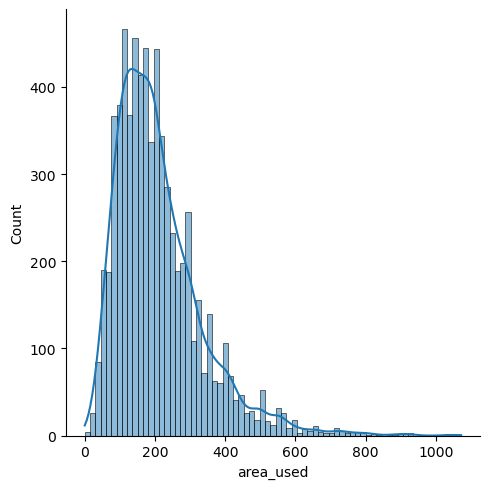

In [ ]:
# View the distribution of the area_used
sns.displot(data['area_used'], kde = True)
plt.show()

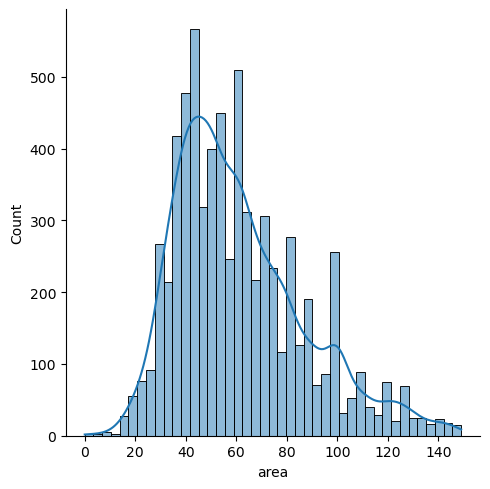

In [ ]:
# View the distribution of the area
sns.displot(data['area'], kde = True)
plt.show()

Có thể thấy rõ rằng phân phối của `area_used` smooth hơn của `area`

#### Add `population_density` of location to features
- Chúng em đã lấy dữ liệu mật độ dân số Việt Nam được tổng hợp trên Wikipedia ở [đây](https://vi.wikipedia.org/wiki/Danh_s%C3%A1ch_%C4%91%C6%A1n_v%E1%BB%8B_h%C3%A0nh_ch%C3%ADnh_c%E1%BA%A5p_huy%E1%BB%87n_c%E1%BB%A7a_Vi%E1%BB%87t_Nam).

- Số liệu dân số được lấy chủ yếu từ Kết quả toàn bộ Tổng điều tra dân số và nhà ở năm 2019.

Vì không tìm được các dữ liệu có thể tải về (chỉ có dữ liệu các năm rất xa như năm 2009) và dữ liệu ở trên cũng được trình bày ở dạng bảng (có thể copy vào Excel) nên chúng em đã copy chúng về Excel và lưu thành file csv.

In [ ]:
population_density = pd.read_csv('https://raw.githubusercontent.com/nauxqouh/house_data/main/population_density.csv')
population_density.head()

Số thứ tự Tên đơn vị hành chính  Tỉnh/Thành phố Chú thích  Dân số (người)  \
0          1                A Lưới  Thừa Thiên Huế       NaN          5637.0   
1          2               An Biên      Kiên Giang       NaN        115218.0   
2          3              An Dương       Hải Phòng       NaN        195717.0   
3          4                An Khê         Gia Lai    thị xã         65918.0   
4          5                An Lão       Hải Phòng       NaN        146712.0   

   Diện tích (km²)  Mật độ dân số (người/km²)  Số ĐVHC cấp xã  
0           1225.2                         46            18.0  
1            400.3                        288             9.0  
2            104.2                       1878            16.0  
3            200.1                        329            11.0  
4            117.7                       1246            17.0

In [ ]:
population_density = population_density.rename(columns={"Tên đơn vị hành chính": "district", \
                                                        "Tỉnh/Thành phố": "province", \
                                                        "Mật độ dân số (người/km²)": "population_density"})

population_density = population_density[['district', 'province', 'population_density']]

In [ ]:
population_density['location'] = population_density.apply(lambda row: f"{row['province']}, {row['district']}", axis=1)
population_density = population_density.drop(columns=['district', 'province'])

In [ ]:
population_density.head()

population_density                location
0                  46  Thừa Thiên Huế, A Lưới
1                 288     Kiên Giang, An Biên
2                1878     Hải Phòng, An Dương
3                 329         Gia Lai, An Khê
4                1246       Hải Phòng, An Lão

In [ ]:
population_density.describe()

population_density
count          707.000000
mean          1529.363508
std           4929.788074
min             10.000000
25%            115.000000
50%            329.000000
75%            925.500000
max          41745.000000

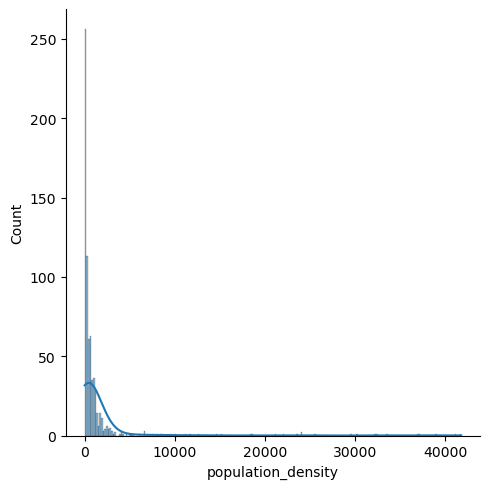

In [ ]:
# Xem phân phối của cột population density
sns.displot(population_density['population_density'], kde = True)
plt.show()

Vì mật độ dân số (population_density) là các giá trị thực tế được cung cấp từ các nguồn đáng tin cậy nên chúng ta sẽ không loại bỏ chúng như loại bỏ outliers.

Nhưng có thể thấy phân bố dữ liệu của mật độ dân số có sự khác biệt rõ rệt ở nhiều nơi, các thành phố lớn như TP Hồ Chí Minh và Hà Nội sẽ có mật độ dân số cao hơn rất nhiều so với những nơi khác.

Do đó chúng ta cần phải giảm sự chênh lệch ấy lại, ở đây ta sẽ lấy logarit cho cột population_density.


In [ ]:
population_density['population_density'] = np.log(population_density['population_density'])

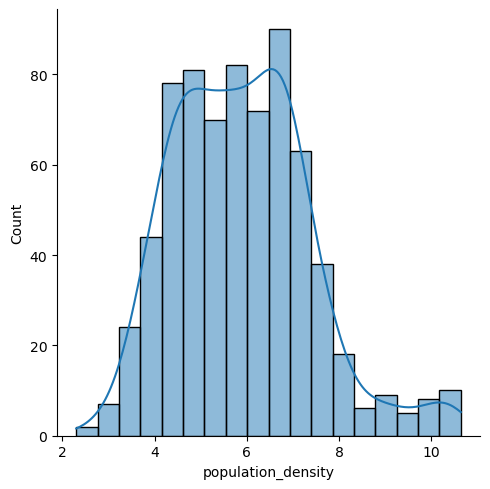

In [ ]:
# Phân phối của cột population_density sau khi lấy logarit
sns.displot(population_density['population_density'], kde = True)
plt.show()

Như vậy phân phối của cột population_density đã có dạng hình chuông hơn, giảm thiểu sự khác biệt quá lớn giữa các giá trị.

In [ ]:
population_density

population_density                location
0              3.828641  Thừa Thiên Huế, A Lưới
1              5.662960     Kiên Giang, An Biên
2              7.537963     Hải Phòng, An Dương
3              5.796058         Gia Lai, An Khê
4              7.127694       Hải Phòng, An Lão
..                  ...                     ...
702            7.594884     Bắc Ninh, Yên Phong
703            4.912655    Tuyên Quang, Yên Sơn
704            6.311735      Nghệ An, Yên Thành
705            5.799093      Bắc Giang, Yên Thế
706            5.337538      Hòa Bình, Yên Thủy

[707 rows x 2 columns]

In [ ]:
# Merge the data based on the 'location' column
data = pd.merge(data, population_density, on='location', how='left')

In [ ]:
data.head()

area  bedroom   wc  floor  frontage       house_type  price  month_posted  \
0  51.0      3.0  3.0    3.0     False    Bán Nhà riêng    5.5            12   
1  45.0      2.0  2.0    2.0     False          Bán Nhà    4.6            12   
2  41.0      2.0  2.0    2.0     False    Bán Nhà riêng   35.0            12   
3  96.0      2.0  1.0    1.0     False    Bán Nhà riêng    5.0            12   
4  91.0      3.0  3.0    3.0     False  Bán Nhà mặt phố    3.5            12   

                    location  area_used  population_density  
0   TP Hồ Chí Minh, Tân Bình      153.0            9.961568  
1  TP Hồ Chí Minh, Phú Nhuận       90.0           10.418136  
2     TP Hồ Chí Minh, Quận 5       82.0           10.518511  
3    TP Hồ Chí Minh, Tân Phú       96.0           10.313808  
4    TP Hồ Chí Minh, Thủ Đức      273.0            9.318118

In [ ]:
data['house_type'].value_counts()

house_type
Bán Nhà riêng      4900
Bán Nhà mặt phố    1487
Bán Nhà             382
Bán Luxury home      75
Bán Nhà cổ            4
Name: count, dtype: int64

/tmp/ipykernel_54092/3979403164.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_54092/3979403164.py:2: UserWarning:


The palette list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.



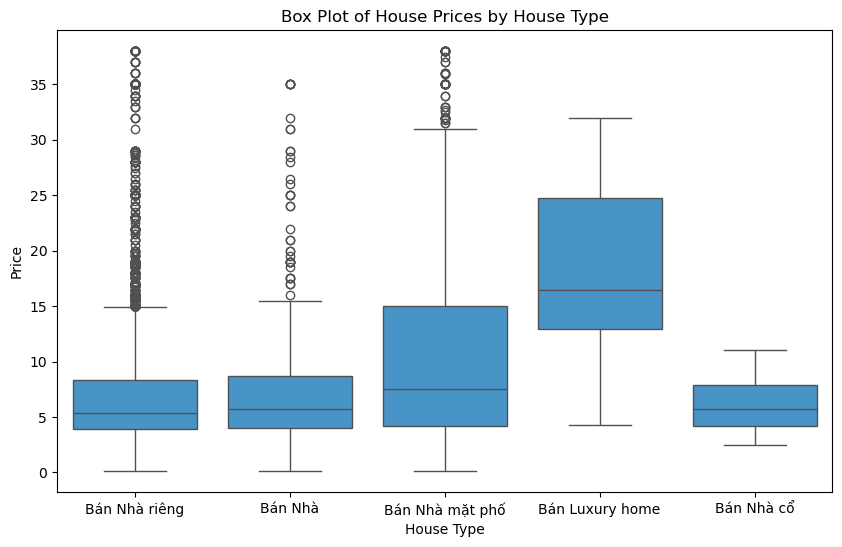

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='house_type', y='price', data=data, palette=["#3498db"])
plt.title('Box Plot of House Prices by House Type')
plt.xlabel('House Type')
plt.ylabel('Price')
plt.show()

Do `Bán Nhà riêng`, `Bán Nhà`, `Bán Nhà cổ` có độ phân tán tương tự nhau nên ta gộp chúng lại với nhau.

In [ ]:
# gộp 'Bán Nhà cổ', 'Bán Nhà riêng' vào 'Bán Nhà'
data['house_type'] = data['house_type'].replace({'Bán Nhà cổ': 'Normal House',\
                                                 'Bán Nhà riêng': 'Normal House',\
                                                 'Bán Nhà': 'Normal House',\
                                                 'Bán Nhà mặt phố': 'Front House',\
                                                 'Bán Luxury home': 'Luxury House'})

/tmp/ipykernel_54092/3979403164.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_54092/3979403164.py:2: UserWarning:


The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.



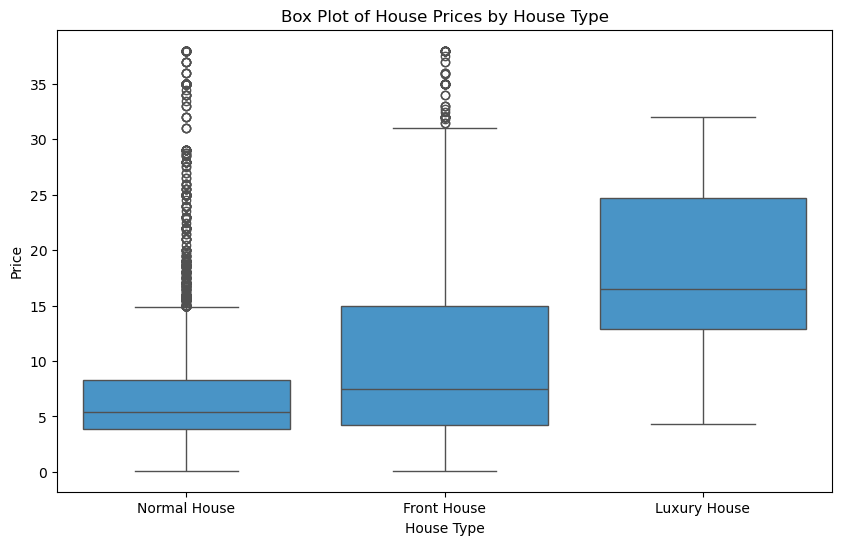

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='house_type', y='price', data=data, palette=["#3498db"])
plt.title('Box Plot of House Prices by House Type')
plt.xlabel('House Type')
plt.ylabel('Price')
plt.show()

#### Add `longitude` and `latitude` to features by `location`

`longitude`, `latitude` được thêm vào để thể hiện ý nghĩa rõ ràng hơn của vị trí địa lý vì bản thân chúng là những biến *numerical* thay vì `location` chỉ là biến *categorical*. Phía dưới, nhóm sẽ sử dụng với 2 mục đích:
- __Clustering:__ phân cụm dữ liệu bằng KMeans dựa vào vị trí địa lý, mục đích để xem sự phân bố của dữ liệu trên đất nước Việt Nam.
- __EDA:__ trực quan các điểm dữ liệu trên bản đồ

Sử dụng **Nominatim** *geopy.geocoders* để trích xuất `longitude`, `latitude` từ `location`

In [ ]:
def geocoding(address, geolocator, max_retries=3):
    retries = 0
    while retries < max_retries:
        try:
            location = geolocator.geocode(address)
            if location:
                return (location.latitude, location.longitude)
            else:
                return (None, None)
        except Exception as e:
            address = re.sub(r'TP ', '', address)
            retries += 1
            time.sleep(5)
    print(f'Error:')
    return (None, None)

In [ ]:
def geocoding_df(df):
    geolocator = Nominatim(user_agent='LatLongGeocoder')

    if 'latitude' not in df.columns:
        df['latitude'] = None
    if 'longitude' not in df.columns:
        df['longitude'] = None

    for i, row in df.iterrows():
        start_time = time.time()
        address = row['location']
        latitude, longitude = geocoding(address, geolocator)
        df.at[i, 'latitude'] = latitude
        df.at[i, 'longitude'] = longitude
        stop_time = time.time()
        if (latitude, longitude) != (None,None):
            print(f'Geocoded row: {i} \tTime: {str(stop_time - start_time)}  \tLatitude: {str(latitude)} \tLongitude: {str(longitude)}')
        else:
            print('Geocoded fail')

    return df


In [ ]:
# data = geocoding_df(data)
# data.to_csv('final_data.csv', index=False)

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/nauxqouh/house_data/main/final_data.csv')
data

area  bedroom   wc  floor  frontage    house_type  price  month_posted  \
0      51.0      3.0  3.0    3.0     False  Normal House    5.5            12   
1      45.0      2.0  2.0    2.0     False  Normal House    4.6            12   
2      41.0      2.0  2.0    2.0     False  Normal House   35.0            12   
3      96.0      2.0  1.0    1.0     False  Normal House    5.0            12   
4      91.0      3.0  3.0    3.0     False   Front House    3.5            12   
...     ...      ...  ...    ...       ...           ...    ...           ...   
6843   31.0      3.0  3.0    3.0     False  Normal House    5.5             4   
6844   40.0      4.0  3.0    5.0     False  Normal House    4.1             4   
6845   40.0      3.0  4.0    5.0     False  Normal House    3.5             4   
6846   30.0      2.0  2.0    2.0     False  Normal House    3.2             4   
6847  100.0      4.0  4.0    3.0     False   Front House    5.7             4   

                       location  area_used  population_density   longitude  \
0      TP Hồ Chí Minh, Tân Bình      153.0            9.961568  106.652116   
1     TP Hồ Chí Minh, Phú Nhuận       90.0           10.418136  106.679438   
2        TP Hồ Chí Minh, Quận 5       82.0           10.518511  106.668544   
3       TP Hồ Chí Minh, Tân Phú       96.0           10.313808  106.627843   
4       TP Hồ Chí Minh, Thủ Đức      273.0            9.318118  106.761790   
...                         ...        ...                 ...         ...   
6843     TP Hồ Chí Minh, Gò Vấp       93.0            8.142063  106.673960   
6844          Hà Nội, Hoàng Mai      200.0            9.438591  105.862656   
6845          Hà Nội, Hoàng Mai      200.0            9.438591  105.862656   
6846     TP Hồ Chí Minh, Gò Vấp       60.0            8.142063  106.673960   
6847            Đà Nẵng, Cẩm Lệ      300.0            6.098074  108.201309   

       latitude  
0     10.802583  
1     10.800981  
2     10.755362  
3     10.791497  
4     10.829830  
...         ...  
6843  10.834563  
6844  20.975758  
6845  20.975758  
6846  10.834563  
6847  16.015305  

[6848 rows x 13 columns]

Sau đó ta sẽ phân cụm tọa độ dựa trên `longitude` và `latitude`

In [ ]:
# Lấy ra tọa độ longitude và latitude để phân cụm
coordinates = data[['longitude', 'latitude']]
coordinates

longitude   latitude
0     106.652116  10.802583
1     106.679438  10.800981
2     106.668544  10.755362
3     106.627843  10.791497
4     106.761790  10.829830
...          ...        ...
6843  106.673960  10.834563
6844  105.862656  20.975758
6845  105.862656  20.975758
6846  106.673960  10.834563
6847  108.201309  16.015305

[6848 rows x 2 columns]

In [ ]:
from sklearn.cluster import KMeans

# Initialize clusters range to experiment with from 2 to 10
clusters_range = range(2, 11)

inertia_values = []
for k in clusters_range:
    kmeans_i = KMeans(n_clusters=k, random_state=1, n_init=10)
    kmeans_i.fit(coordinates)
    inertia_values.append(kmeans_i.inertia_)

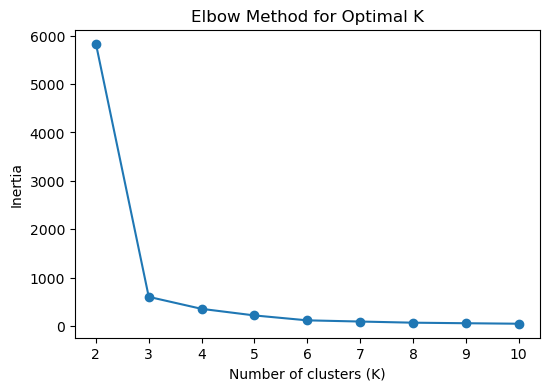

In [ ]:
# Vẽ Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(clusters_range, inertia_values, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, max_iter=10000, random_state=1, n_init=10)

kmeans.fit(coordinates)

KMeans(max_iter=10000, n_clusters=3, n_init=10, random_state=1)

In [ ]:
# Lấy labels của tọa độ sau khi phân cụm
labels = kmeans.labels_

# Thêm cột cluster bằng vị trí địa lý của longitude và latitude vào data
data.loc[:, 'geo_cluster'] = labels

In [ ]:
# Xem số lượng của từng phân cụm
data['geo_cluster'].value_counts()

geo_cluster
1    4397
0    2244
2     207
Name: count, dtype: int64

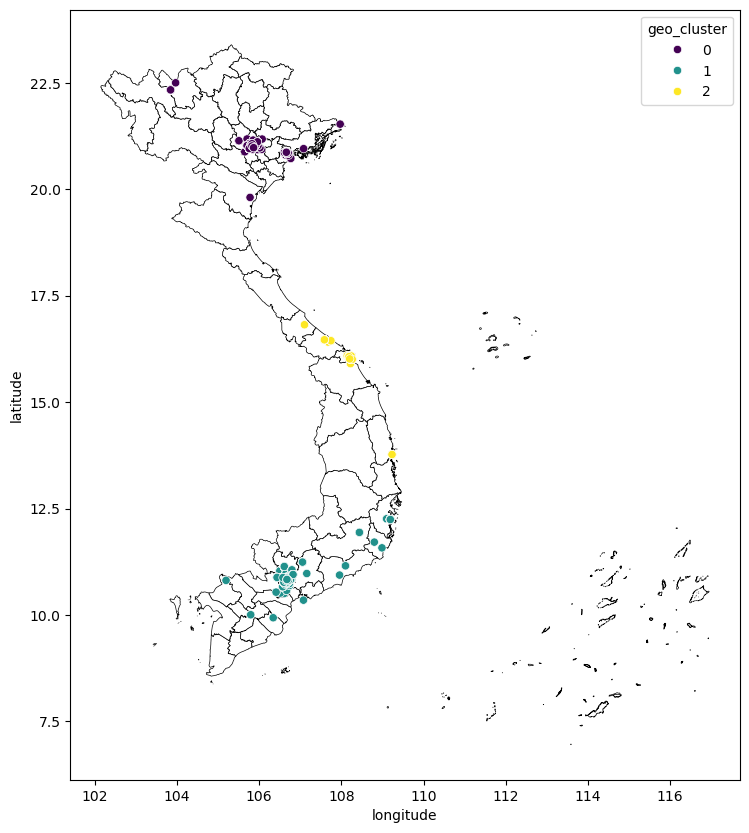

In [ ]:
# Đọc dữ liệu từ GeoJSON hoặc từ DataFrame đã có
url = 'https://data.opendevelopmentmekong.net/dataset/55bdad36-c476-4be9-a52d-aa839534200a/resource/b8f60493-7564-4707-aa72-a0172ba795d8/download/vn_iso_province.geojson'
vietnam_province = gpd.read_file(url)
# Sự phân bố bài đăng bán nhà ở các khu vực
fig, (ax1) = plt.subplots(ncols=1, figsize=(15, 10))
# Plot the map of Vietnam on the first subplot
vietnam_province.plot(ax=ax1, color='white', edgecolor='black', linewidth=0.5)

sns.scatterplot(data=data, x='longitude', y='latitude', hue='geo_cluster', palette='viridis')
plt.show()

Trực quan kết quả trên bản đồ địa lý Việt Nam sau khi thực hiện phân cụm dữ liệu


#### Visualize before modeling

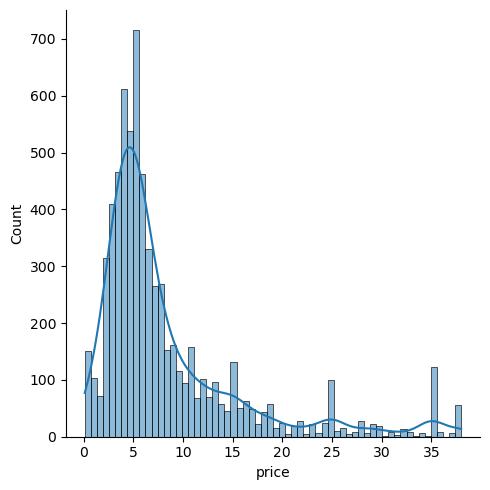

In [ ]:
# Xem phân phối của biến target price
sns.displot(data = data, x = 'price', kde = True)

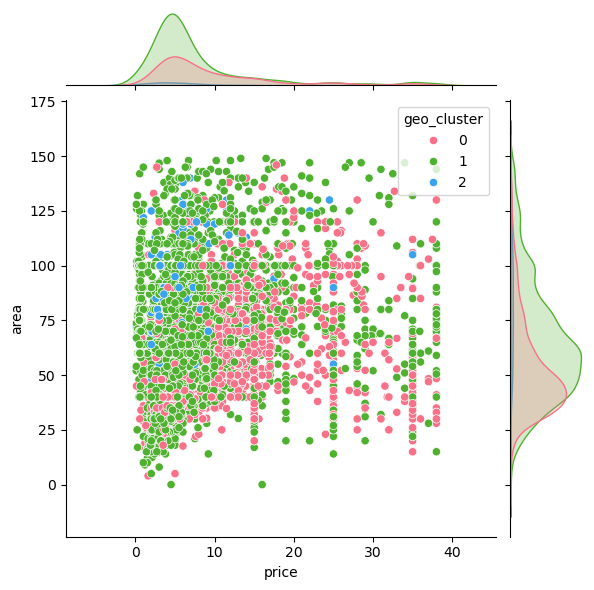

In [ ]:
# giá nhà và diện tích theo 3 khu vực
palette = sns.color_palette("husl", n_colors=len(data['geo_cluster'].unique()))
sns.jointplot(data = data, x = 'price', y = 'area', hue = "geo_cluster", palette=palette)

In [ ]:
data

area  bedroom   wc  floor  frontage    house_type  price  month_posted  \
0      51.0      3.0  3.0    3.0     False  Normal House    5.5            12   
1      45.0      2.0  2.0    2.0     False  Normal House    4.6            12   
2      41.0      2.0  2.0    2.0     False  Normal House   35.0            12   
3      96.0      2.0  1.0    1.0     False  Normal House    5.0            12   
4      91.0      3.0  3.0    3.0     False   Front House    3.5            12   
...     ...      ...  ...    ...       ...           ...    ...           ...   
6843   31.0      3.0  3.0    3.0     False  Normal House    5.5             4   
6844   40.0      4.0  3.0    5.0     False  Normal House    4.1             4   
6845   40.0      3.0  4.0    5.0     False  Normal House    3.5             4   
6846   30.0      2.0  2.0    2.0     False  Normal House    3.2             4   
6847  100.0      4.0  4.0    3.0     False   Front House    5.7             4   

                       location  area_used  population_density   longitude  \
0      TP Hồ Chí Minh, Tân Bình      153.0            9.961568  106.652116   
1     TP Hồ Chí Minh, Phú Nhuận       90.0           10.418136  106.679438   
2        TP Hồ Chí Minh, Quận 5       82.0           10.518511  106.668544   
3       TP Hồ Chí Minh, Tân Phú       96.0           10.313808  106.627843   
4       TP Hồ Chí Minh, Thủ Đức      273.0            9.318118  106.761790   
...                         ...        ...                 ...         ...   
6843     TP Hồ Chí Minh, Gò Vấp       93.0            8.142063  106.673960   
6844          Hà Nội, Hoàng Mai      200.0            9.438591  105.862656   
6845          Hà Nội, Hoàng Mai      200.0            9.438591  105.862656   
6846     TP Hồ Chí Minh, Gò Vấp       60.0            8.142063  106.673960   
6847            Đà Nẵng, Cẩm Lệ      300.0            6.098074  108.201309   

       latitude  geo_cluster  
0     10.802583            1  
1     10.800981            1  
2     10.755362            1  
3     10.791497            1  
4     10.829830            1  
...         ...          ...  
6843  10.834563            1  
6844  20.975758            0  
6845  20.975758            0  
6846  10.834563            1  
6847  16.015305            2  

[6848 rows x 14 columns]

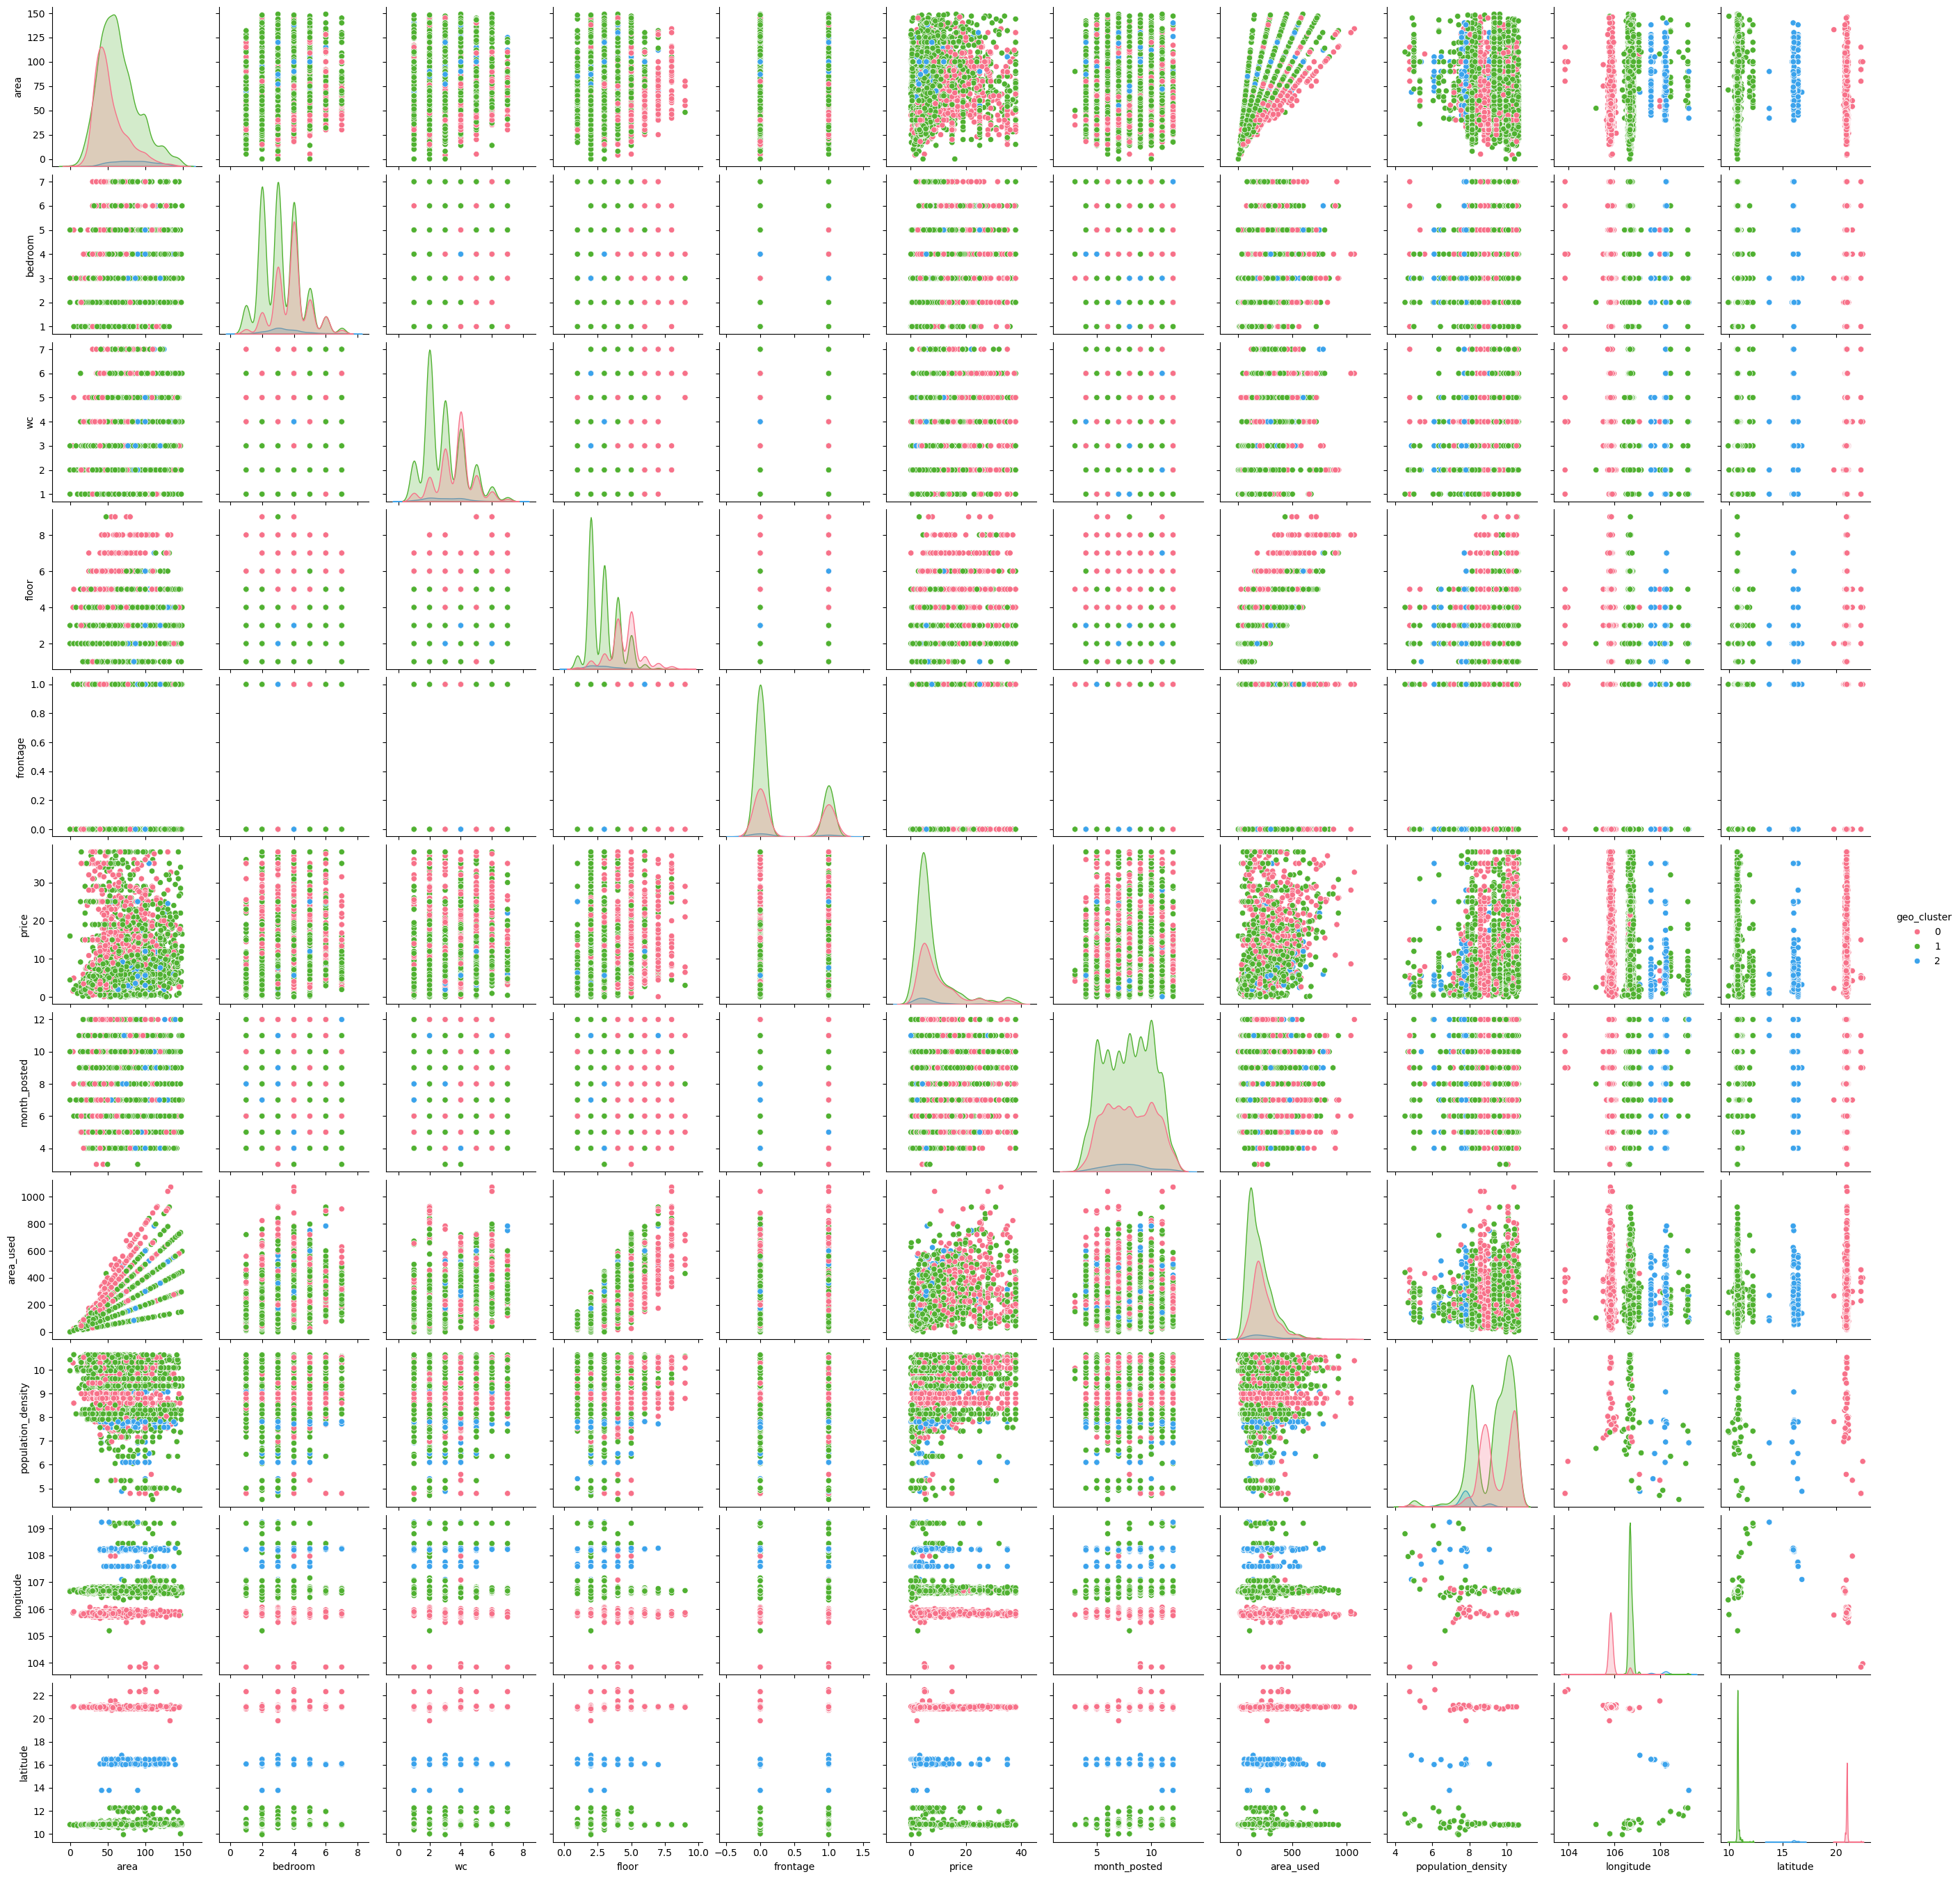

In [ ]:
# Pair plot
sns.pairplot(data = data.drop(columns=['house_type', 'location']), hue = 'geo_cluster', palette=palette)

In [ ]:
import folium
from folium.plugins import HeatMap

# Prepare data for folium
heat_data = [[row['latitude'], row['longitude']] for index, row in data.iterrows()]

# Create a map centered around the mean coordinates
m = folium.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=6)

# Add the heatmap
HeatMap(heat_data).add_to(m)
m

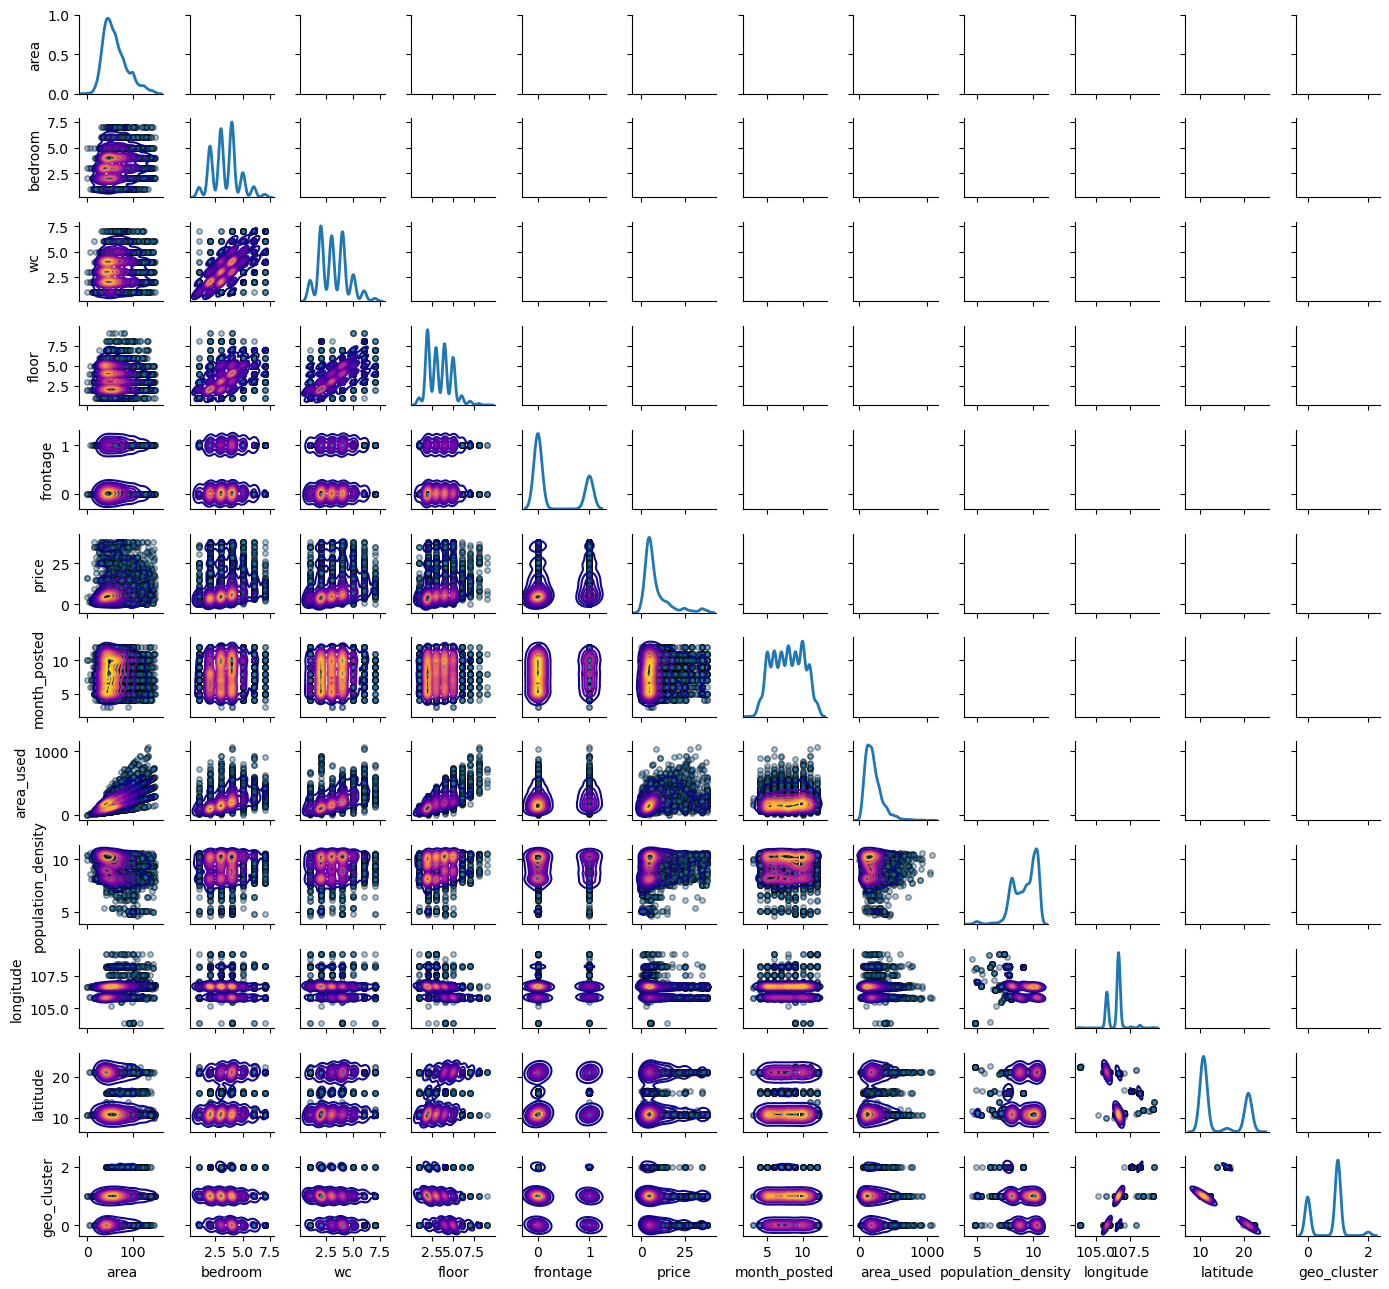

In [ ]:
''' Draw a Bivariate Seaborn Pairgrid /w KDE density w/ '''
def snsPairGrid(df):

    ''' Plots a Seaborn Pairgrid w/ KDE & scatter plot of df features'''
    g = sns.PairGrid(df,diag_sharey=False)
    g.fig.set_size_inches(14,13)
    g.map_diag(sns.kdeplot, lw=2) # draw kde approximation on the diagonal
    g.map_lower(sns.scatterplot,s=15,edgecolor="k",linewidth=1,alpha=0.4) # scattered plot on lower half
    g.map_lower(sns.kdeplot,cmap='plasma',n_levels=10) # kde approximation on lower half
    plt.tight_layout()

# Seaborn get a little slow, let's plot some interesting features
snsPairGrid(data.drop(columns=['house_type', 'location']))

#### Continue encoding categorical variables

##### Target Encoding cho `location`
Vì cột `location` có quá nhiều giá trị phân loại nên sẽ không hợp lí nếu ta dùng One Hot Encoding hay Dummy Coding. Do đó ta sẽ áp dụng Target Encoding cho cột này.

In [ ]:
X = data.drop(columns='price')
y = data['price']

In [ ]:
# Split dataset into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
from category_encoders import MEstimateEncoder

# Fit the encoder on the training set
encoder = MEstimateEncoder(cols=['location'], m=5.0)
encoder.fit(X_train, y_train)

# Encode the training and testing set
X_train = encoder.transform(X_train, y_train)
X_test = encoder.transform(X_test)

In [ ]:
X_train.head()

area  bedroom   wc  floor  frontage    house_type  month_posted  \
445   86.0      3.0  3.0    4.0      True   Front House            11   
2756  88.0      2.0  2.0    2.0     False  Normal House             9   
1494  41.0      5.0  4.0    5.0     False  Normal House            10   
273   33.0      4.0  3.0    4.0     False  Normal House            11   
6594  44.0      3.0  2.0    2.0     False   Front House             5   

      location  area_used  population_density   longitude   latitude  \
445   8.127326      344.0           10.313808  106.627843  10.791497   
2756  7.818456      176.0            9.318118  106.761790  10.829830   
1494  8.745270      205.0            8.989818  105.758011  20.955185   
273   8.260223      132.0            8.376090  105.836508  20.940897   
6594  7.818456       88.0            9.318118  106.761790  10.829830   

      geo_cluster  
445             1  
2756            1  
1494            0  
273             0  
6594            1

In [ ]:
X_test.head()

area  bedroom   wc  floor  frontage    house_type  month_posted  \
6232  50.0      4.0  3.0    3.0     False  Normal House             5   
4640  63.0      4.0  3.0    3.0     False  Normal House             7   
5246  96.0      4.0  3.0    4.0      True  Normal House             6   
231   72.0      6.0  5.0    5.0      True   Front House            11   
5873  60.0      3.0  3.0    4.0     False  Normal House             5   

       location  area_used  population_density   longitude   latitude  \
6232   9.181037      150.0           10.381428  105.817132  20.994417   
4640   8.057266      189.0            9.623046  106.599635  10.770371   
5246   8.057266      384.0            9.623046  106.599635  10.770371   
231   10.991080      360.0            8.593043  105.902192  21.035966   
5873   6.477236      240.0            9.371183  106.660973  10.861604   

      geo_cluster  
6232            0  
4640            1  
5246            1  
231             0  
5873            1

In [ ]:
# Nối các dữ liệu lại sau khi encode
X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)
data = pd.concat([X, y], axis=1)

In [ ]:
data

area  bedroom   wc  floor  frontage    house_type  month_posted  \
0     86.0      3.0  3.0    4.0      True   Front House            11   
1     88.0      2.0  2.0    2.0     False  Normal House             9   
2     41.0      5.0  4.0    5.0     False  Normal House            10   
3     33.0      4.0  3.0    4.0     False  Normal House            11   
4     44.0      3.0  2.0    2.0     False   Front House             5   
...    ...      ...  ...    ...       ...           ...           ...   
6843  66.0      5.0  6.0    4.0     False  Normal House             8   
6844  42.0      3.0  2.0    3.0     False  Normal House             6   
6845  50.0      4.0  3.0    5.0     False  Normal House            11   
6846  75.0      3.0  3.0    3.0      True   Front House             8   
6847  87.0      3.0  2.0    3.0     False  Normal House             7   

      location  area_used  population_density   longitude   latitude  \
0     8.127326      344.0           10.313808  106.627843  10.791497   
1     7.818456      176.0            9.318118  106.761790  10.829830   
2     8.745270      205.0            8.989818  105.758011  20.955185   
3     8.260223      132.0            8.376090  105.836508  20.940897   
4     7.818456       88.0            9.318118  106.761790  10.829830   
...        ...        ...                 ...         ...        ...   
6843  8.057266      264.0            9.623046  106.599635  10.770371   
6844  8.769297      126.0           10.626096  106.668367  10.772732   
6845  8.745270      250.0            8.989818  105.758011  20.955185   
6846  5.370353      225.0            7.967973  105.956861  21.113309   
6847  7.818456      261.0            9.318118  106.761790  10.829830   

      geo_cluster  price  
0               1   13.6  
1               1    5.8  
2               0    6.4  
3               0   33.0  
4               1   15.0  
...           ...    ...  
6843            1    6.2  
6844            1    9.5  
6845            0    3.1  
6846            0    4.0  
6847            1    3.0  

[6848 rows x 14 columns]

##### One-Hot Encoding for `house_type` and `geo_cluster`

In [ ]:
# Hàm encode trên column
def one_hot_encode(df, column, prefix=''):
    df = df.copy()
    if prefix == '':
        dummies = pd.get_dummies(df[column])
    else:
        dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [ ]:
data = one_hot_encode(data, 'house_type')
data.head()

area  bedroom   wc  floor  frontage  month_posted  location  area_used  \
0  86.0      3.0  3.0    4.0      True            11  8.127326      344.0   
1  88.0      2.0  2.0    2.0     False             9  7.818456      176.0   
2  41.0      5.0  4.0    5.0     False            10  8.745270      205.0   
3  33.0      4.0  3.0    4.0     False            11  8.260223      132.0   
4  44.0      3.0  2.0    2.0     False             5  7.818456       88.0   

   population_density   longitude   latitude  geo_cluster  price  Front House  \
0           10.313808  106.627843  10.791497            1   13.6         True   
1            9.318118  106.761790  10.829830            1    5.8        False   
2            8.989818  105.758011  20.955185            0    6.4        False   
3            8.376090  105.836508  20.940897            0   33.0        False   
4            9.318118  106.761790  10.829830            1   15.0         True   

   Luxury House  Normal House  
0         False         False  
1         False          True  
2         False          True  
3         False          True  
4         False         False

In [ ]:
# One hot encode cho cột phân cụm geo_cluster
data = one_hot_encode(data, 'geo_cluster', 'geo_cluster')
data.head()

area  bedroom   wc  floor  frontage  month_posted  location  area_used  \
0  86.0      3.0  3.0    4.0      True            11  8.127326      344.0   
1  88.0      2.0  2.0    2.0     False             9  7.818456      176.0   
2  41.0      5.0  4.0    5.0     False            10  8.745270      205.0   
3  33.0      4.0  3.0    4.0     False            11  8.260223      132.0   
4  44.0      3.0  2.0    2.0     False             5  7.818456       88.0   

   population_density   longitude   latitude  price  Front House  \
0           10.313808  106.627843  10.791497   13.6         True   
1            9.318118  106.761790  10.829830    5.8        False   
2            8.989818  105.758011  20.955185    6.4        False   
3            8.376090  105.836508  20.940897   33.0        False   
4            9.318118  106.761790  10.829830   15.0         True   

   Luxury House  Normal House  geo_cluster_0  geo_cluster_1  geo_cluster_2  
0         False         False          False           True          False  
1         False          True          False           True          False  
2         False          True           True          False          False  
3         False          True           True          False          False  
4         False         False          False           True          False

In [ ]:
# Chuyển tất cả các biến kiểu boolean thành int
for col in data.columns:
    if data[col].dtype == 'bool':
        data[col] = data[col].astype(int)

#### Correlation

In [ ]:
# Calculate correlation coefficients
corr_matrix = data.corr().round(2)
target_corr = corr_matrix['price']

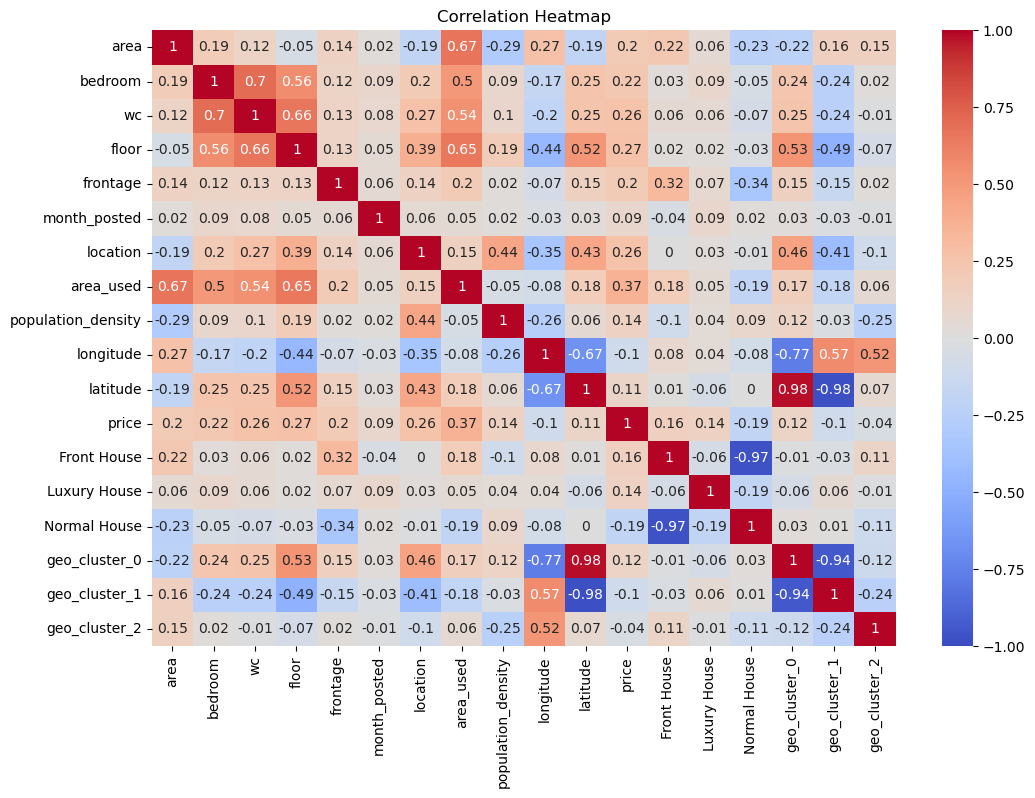

In [ ]:
# Visualize correlations with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

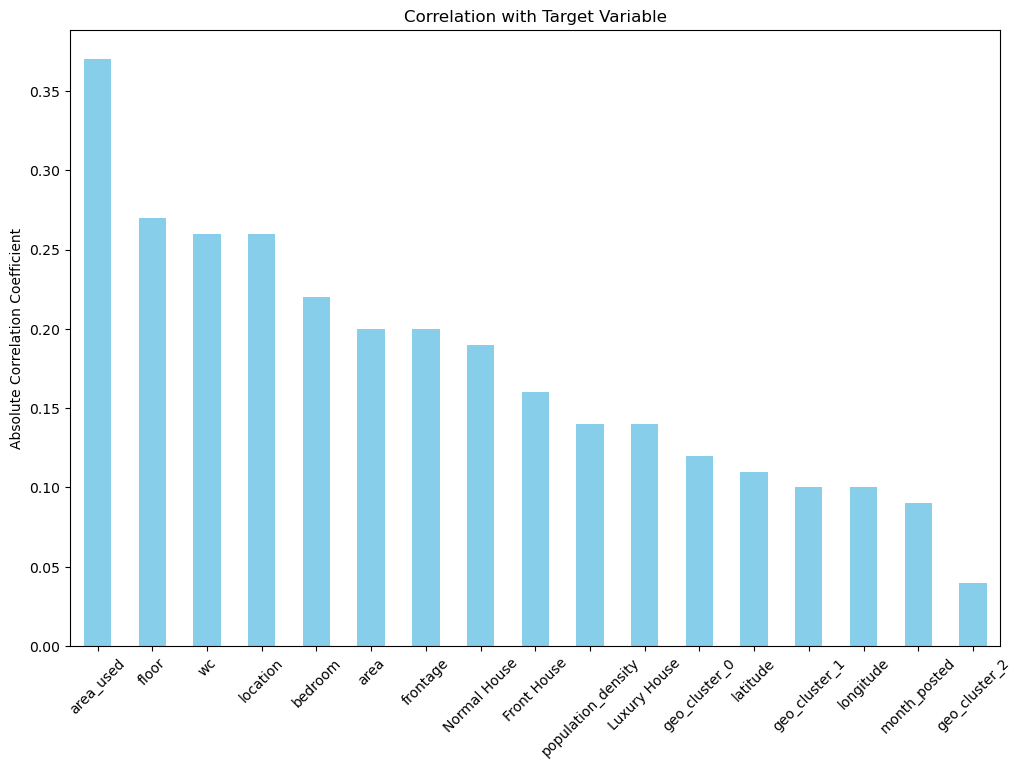

In [ ]:
# Sắp xếp theo thứ tự từ tương quan nhất đến ít tương quan nhất trước khi visualize (lấy trị tuyệt đối để so sánh sự tương quan với target)
target_corr = target_corr.abs().sort_values(ascending=False)

# Visualize correlations giữa features và target bằng bar plot
plt.figure(figsize=(12, 8))
abs_corr = target_corr.drop('price')
abs_corr.plot(kind='bar', color='skyblue')
plt.title('Correlation with Target Variable')
plt.ylabel('Absolute Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Select relevant features with high correlation coefficients
relevant_features = abs_corr[abs_corr >= 0.15].index.tolist()
print("Relevant Features:", relevant_features)
print("Number of relevant features:", len(relevant_features))

Relevant Features: ['area_used', 'floor', 'wc', 'location', 'bedroom', 'area', 'frontage', 'Normal House', 'Front House']
Number of relevant features: 9


In [ ]:
X = data[relevant_features]
y = data['price']

#### Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21062024)
print("Training size:\t", X_train.shape[0])
print("Testing size:\t", X_test.shape[0])

Training size:	 5478
Testing size:	 1370


#### Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler

# Fit the scaler
scaler = MinMaxScaler()
scaler.fit(X_train)

# Transform the training set and testing set for features
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

<a name="6"></a>
## 6. Methodology
Chúng ta sẽ dùng các model sau để so sánh (các model này được nhóm dùng GridSearchCV để tìm ra hyperparameter tối ưu nhất)
- Linear Regression
- Ridge Regression
- Lasso Regression
- DecisionTree Regressor
- Random Forest Regressor
- Gradient Boosting:
  - XGBoost Regressor
  - CatBoost Regressor

In [ ]:
# Hàm đánh giá model sau khi được train qua tập train
def validate_model(model):
    print("Training")
    train_pred = model.predict(X_train)
    print(f">> MSE\t\t{mean_squared_error(y_train, train_pred):.3f}")
    print(f">> MAE\t\t{mean_absolute_error(y_train, train_pred):.3f}")
    print(f">> R-squared\t{r2_score(y_train, train_pred):.3f}")

    print("Testing")
    test_pred = model.predict(X_test)
    print(f">> MSE\t\t{mean_squared_error(y_test, test_pred):.3f}")
    print(f">> MAE\t\t{mean_absolute_error(y_test, test_pred):.3f}")
    print(f">> R-squared\t{r2_score(y_test, test_pred):.3f}")

def validate_return(model):
    test_pred = model.predict(X_test)

    return mean_squared_error(y_test, test_pred), mean_absolute_error(y_test, test_pred), r2_score(y_test, test_pred)

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(X_train, y_train)
validate_model(linear)

Training
>> MSE		44.284
>> MAE		4.033
>> R-squared	0.218
Testing
>> MSE		49.116
>> MAE		4.225
>> R-squared	0.208


### Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
ridge_param = {'alpha': 0.001}
ridge = Ridge(**ridge_param)
ridge.fit(X_train, y_train)
validate_model(ridge)

Training
>> MSE		44.284
>> MAE		4.033
>> R-squared	0.218
Testing
>> MSE		49.116
>> MAE		4.225
>> R-squared	0.208


### Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
lasso_param = {'alpha': 0.001}
lasso = Lasso(**lasso_param)
lasso.fit(X_train, y_train)
validate_model(lasso)

Training
>> MSE		44.288
>> MAE		4.033
>> R-squared	0.218
Testing
>> MSE		49.156
>> MAE		4.227
>> R-squared	0.208


### Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
validate_model(decision_tree)

Training
>> MSE		5.835
>> MAE		0.512
>> R-squared	0.897
Testing
>> MSE		76.854
>> MAE		4.858
>> R-squared	-0.239


### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_param = {'bootstrap': True, 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1000}
random_forest = RandomForestRegressor(**rf_param)
random_forest.fit(X_train, y_train)
validate_model(random_forest)

Training
>> MSE		31.859
>> MAE		3.350
>> R-squared	0.437
Testing
>> MSE		47.044
>> MAE		4.074
>> R-squared	0.242


### XGBoost

In [ ]:
from xgboost import XGBRegressor
xgb_param = {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.6}
xgb_model = XGBRegressor(**xgb_param)
xgb_model.fit(X_train, y_train)
validate_model(xgb_model)

Training
>> MSE		32.027
>> MAE		3.351
>> R-squared	0.434
Testing
>> MSE		47.483
>> MAE		4.088
>> R-squared	0.235


### CatBoost Regressor

In [ ]:
from catboost import CatBoostRegressor
catboost_param = {'iterations': 500,'devices': 0, 'learning_rate': 0.05, 'loss_function': 'RMSE', 'max_depth': 6, 'verbose': 0}
catboost = CatBoostRegressor(**catboost_param)
catboost.fit(X_train, y_train)
validate_model(catboost)

Training
>> MSE		33.947
>> MAE		3.464
>> R-squared	0.401
Testing
>> MSE		47.136
>> MAE		4.073
>> R-squared	0.240


### Comparison and Result

In [ ]:
models = {'linear': linear,
         'lasso': lasso,
         'ridge': ridge,
         'decision_tree': decision_tree,
         'random_forest': random_forest,
         'xgboost': xgb_model,
         'catboost': catboost}

# Lưu trữ kết quả
results = {
    'Model': [],
    'MSE': [],
    'MAE': [],
    'R2': []
}

# Đánh giá các mô hình
for name, model in models.items():
    mse, mae, r2 = validate_return(model)
    results['Model'].append(name)
    results['MSE'].append(mse)
    results['MAE'].append(mae)
    results['R2'].append(r2)

# Tạo DataFrame từ kết quả
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='MSE')
df_results

Model        MSE       MAE        R2
4  random_forest  47.043665  4.073827  0.241820
6       catboost  47.136262  4.072531  0.240328
5        xgboost  47.483248  4.087922  0.234736
0         linear  49.116138  4.225337  0.208419
2          ridge  49.116276  4.225343  0.208417
1          lasso  49.156077  4.226551  0.207775
3  decision_tree  76.854116  4.858190 -0.238620

Mô hình tốt nhất của nhóm là __Random Forest Regressor__

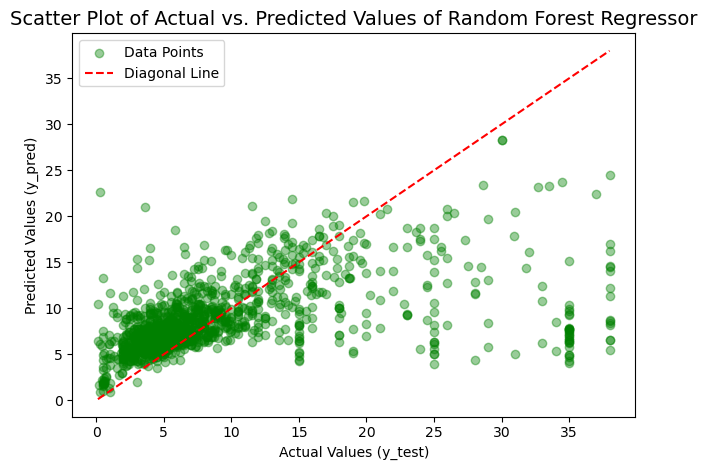

In [ ]:
# Dự đoán bằng mô hình random forest trên X_test
y_pred = random_forest.predict(X_test)

plt.scatter(y_test, y_pred, color = 'g', label='Data Points', alpha=0.4)
# diagonal line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--', label='Diagonal Line')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Scatter Plot of Actual vs. Predicted Values of Random Forest Regressor', size = 14)
plt.legend()

plt.tight_layout()
plt.show()

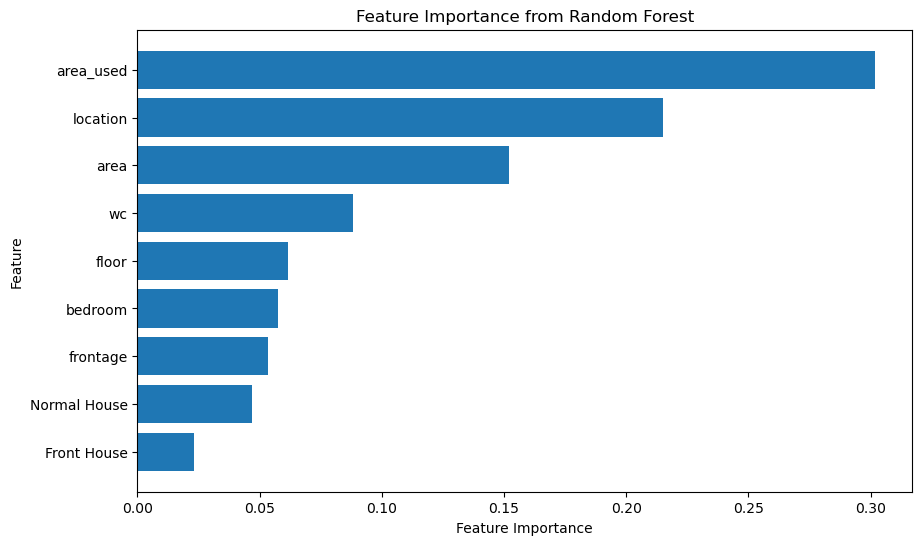

In [ ]:
# Get feature importances
feature_importances = random_forest.feature_importances_

# Create a DataFrame for easy visualization
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

<a name="7"></a>
## 7. Self-Assessment

Chúng em sẽ trình bày những gì chúng em học được sau đồ án theo thứ tự từ trên xuống trong notebook. Đây là những phương pháp đã được chúng em sử dụng và chọn ra những phương pháp có hiệu quả nhất đề đưa vào bài làm.
- Biết cách cào dữ liệu từ trang web, biết cách dùng RegEx và LLM để trích xuất các dữ liệu có ích.
- Biết thêm nhiều phương thức xử lý outliers, xử lý missing values và xử lý categorical variables khác nhau:
    - Handling outliers
        - Xử lý các dữ liệu bất thường
        - Phương pháp IQR
        - _Phương pháp capping outliers (thử nghiệm)_
    - Handling missing value
        - Fill missing value cho 1 feature dựa trên các cột có sự tương quan cao
        - _MICE Imputation (thử nghiệm)_
        - _KNN Imputation (thử nghiệm)_
    - Handling categorical variable
        - One hot encoding
        - Target encoding
- Có nhiều ý tưởng Feature Engineering khác nhau:
    - Thêm cột mới dựa trên sự tương tác giữa cột sẵn có (`area_used`)
    - Khai thác thêm các features dựa trên dữ liệu có sẵn (`population_density`, `longitude`, `latitude`)
    - Biết thêm về phân cụm dựa trên vị trí địa lý
- Biết được thêm các phương pháp EDA mới
    - Có thể trực quan hóa dữ liệu trên bản đồ (dùng folium, thư viện geopandas).
    - Trực quan heatmap sử dụng kernel density estimation (KDE).
- Biết thêm phương pháp học bán giám sát (nhưng vì không có kết quả cao và số lượng dữ liệu chưa có nhãn là không quá đáng kể so với số lượng dữ liệu hiện có nên đã không áp dụng vào bài làm)
    - Self-Training
- Hiểu hơn về các advanced model
    - Decision Tree Regressor
    - Random Forest Regressor
    - XGBoost Regressor
    - CatBoost Regressor
    - Neural Network using PyTorch

## Thank you for viewing our project